# installation

In [1]:
%pip install scikit-image pandas matplotlib tqdm torchinfo tensorboard wandb scikit-learn pytorch-msssim opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 83.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 84.8 MB/s eta 0:00:00:00:01:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 87.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 102.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 90.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 64.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 33.2 MB/s 

# Config

In [17]:
import os
import torch
import psutil
from util import format
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import DeepLenseSuperresolutionDataset
import matplotlib.pyplot as plt 
from torchinfo import summary
from util import run_experiment_task2, MSE_Metric, PSNR_Metric, SSIM_Metric
import math

# PyTorch imports
import torch.nn as nn
import torch.nn.functional as F
import multiprocessing

class CONFIG:
    BATCH_SIZE = 4
    
    # limit the data to prototype faster
    DATA_LIMIT = 200
    
    DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    ROUND_NUMBER = 3
    TASK_NAME = "DeepLense2024_task2A"
    DATA_PATH = os.path.join("Data", "Superresolution")
    PORTION_OF_DATA_FOR_TRAINING = 0.9

    PIN_MEMORY = True
    
    NUM_WORKERS = min(multiprocessing.cpu_count() - 5, BATCH_SIZE)

# weird thing on windows : if not set to 0, a dramatic performance drop (very not expected ?)
CONFIG.NUM_WORKERS = 0
    
# enabled for speed
torch.backends.cudnn.benchmark = True
print(f"Device : {CONFIG.DEVICE}")

Device : cuda


In [18]:
memory_start = psutil.virtual_memory()
print(f"RAM used : {format(memory_start.used)}")

RAM used : 14.24GB


In [19]:
dataset = DeepLenseSuperresolutionDataset(folder_path=CONFIG.DATA_PATH, 
                                          randomize_dataset=True,
                                          data_limit=CONFIG.DATA_LIMIT)

# do train/val split
dataset_size = len(dataset)
train_size = int(dataset_size * CONFIG.PORTION_OF_DATA_FOR_TRAINING)
val_size = dataset_size - train_size

print(f"splitting into : {train_size} {val_size}")

# splitting dataset 
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"sizes of datasets : len(train)={len(train_dataset)} len(val)={len(val_dataset)}")

# Create Dataloaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, pin_memory=CONFIG.PIN_MEMORY, num_workers=CONFIG.NUM_WORKERS,  shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE, pin_memory=CONFIG.PIN_MEMORY, num_workers=CONFIG.NUM_WORKERS)

Data\Superresolution\LR Data\Superresolution\HR


Loading dataset : :   0%|          | 0/200 [00:00<?, ?it/s]

preprocessing :: 100%|██████████| 200/200 [00:00<00:00, 836.36it/s]


splitting into : 180 20
sizes of datasets : len(train)=180 len(val)=20


In [20]:
# get sample batch, useful for prototyping the architectures
x, y = next(iter(train_loader))

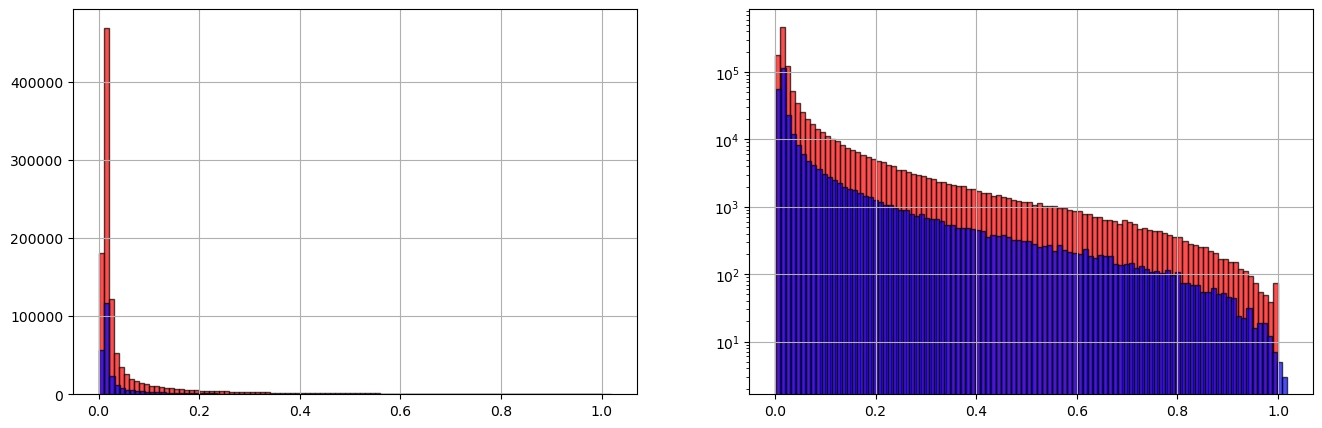

In [10]:
# sanity check 
a = 0.7
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.hist(dataset.HR_data.numpy().reshape(-1), bins=100, color="red", edgecolor="black", alpha=a, label="HR")
plt.hist(dataset.LR_data.numpy().reshape(-1), bins=100, color="blue", edgecolor="black", alpha=a, label="LR")
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(dataset.HR_data.numpy().reshape(-1), bins=100, color="red", edgecolor="black", alpha=a, label="HR")
plt.hist(dataset.LR_data.numpy().reshape(-1), bins=100, color="blue", edgecolor="black", alpha=a, label="LR")
plt.yscale("log")
plt.grid()
plt.show()


In [11]:
try:
    print(f"mean_LR = {dataset.mean_LR.item()} std_LR = {dataset.std_LR.item()}")
except Exception as e:
    print(f"mean_LR = {dataset.mean_LR} std_LR = {dataset.std_LR}")


try:
    print(f"mean_HR = {dataset.mean_HR.item()} std_HR = {dataset.std_HR.item()}")
except Exception as e:
    print(f"mean_HR = {dataset.mean_HR} std_HR = {dataset.std_HR}")
    

memory_after = psutil.virtual_memory()
print(f"RAM used : {format(memory_after.used)}, RAM free : {format(memory_after.free)}, memory used : {format(memory_after.used - memory_start.used)}")

mean_LR = 0.06329753994941711 std_LR = 0.12216157466173172
mean_HR = 0.06329753994941711 std_HR = 0.12211320549249649
RAM used : 14.97GB, RAM free : 760.11MB, memory used : 1.62GB


# SRCNN

Paper : https://arxiv.org/abs/1501.00092

In [9]:
class SRCNN_upsampler(nn.Module):
    def __init__(self) -> None:
        super(SRCNN_upsampler, self).__init__()
        
        self.upsampler = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)        
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 128, (9, 9), (1, 1), (4, 4)),
            nn.ReLU(True)
        )

        self.map = nn.Sequential(
            nn.Conv2d(128, 64, (5, 5), (1, 1), (2, 2)),
            nn.ReLU(True)
        )

        self.reconstruction = nn.Conv2d(64, 1, (5, 5), (1, 1), (2, 2))

        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.upsampler is not None:
            x = self.upsampler(x)
        return self._forward_impl(x)

    # Support torch.script function.
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        out = self.features(x)
        out = self.map(out)
        out = self.reconstruction(out)
        return out

    # The filter weight of each layer is a Gaussian distribution with zero mean and
    # standard deviation initialized by random extraction 0.001 (deviation is 0)
    def _initialize_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight.data, 0.0, math.sqrt(2 / (module.out_channels * module.weight.data[0][0].numel())))
                nn.init.zeros_(module.bias.data)

        nn.init.normal_(self.reconstruction.weight.data, 0.0, 0.001)
        nn.init.zeros_(self.reconstruction.bias.data)

## Run for upsampler layer

In [10]:
model  = SRCNN_upsampler()
model(x).shape
summary(model, input_size=(CONFIG.BATCH_SIZE, 1, 75, 75))

Layer (type:depth-idx)                   Output Shape              Param #
SRCNN_upsampler                          [4, 1, 150, 150]          --
├─Upsample: 1-1                          [4, 1, 150, 150]          --
├─Sequential: 1-2                        [4, 128, 150, 150]        --
│    └─Conv2d: 2-1                       [4, 128, 150, 150]        10,496
│    └─ReLU: 2-2                         [4, 128, 150, 150]        --
├─Sequential: 1-3                        [4, 64, 150, 150]         --
│    └─Conv2d: 2-3                       [4, 64, 150, 150]         204,864
│    └─ReLU: 2-4                         [4, 64, 150, 150]         --
├─Conv2d: 1-4                            [4, 1, 150, 150]          1,601
Total params: 216,961
Trainable params: 216,961
Non-trainable params: 0
Total mult-adds (G): 19.53
Input size (MB): 0.09
Forward/backward pass size (MB): 138.96
Params size (MB): 0.87
Estimated Total Size (MB): 139.92

In [12]:
import util

util.run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=SRCNN_upsampler, 
                     run_name="SRCNN_upsample", 
                     model_parameters={}, 
                     epochs=30,
                     learning_rate=1e-4, 
                     optimizer='adam',
                     savepath="models/srcnn_upsample.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     test_params={"save_in_total" : 10},
                     min_lr=5e-5,
                     cosine_annealer_epochs=10,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

examples seen so far : 904 Mean Squared Error (MSE)=0.017340709361457086 ; PSNR=17.76590000144139 ; SSIM=0.22122938137249826 ; :  12%|█▏        | 265/2250 [00:11<01:24, 23.60it/s]


KeyboardInterrupt: 

## Run for Conv2DTranspose

In [13]:

class SRCNN_conv2DTranspose(nn.Module):
    def __init__(self) -> None:
        super(SRCNN_conv2DTranspose, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 128, (9, 9), (1, 1), (4, 4)),
            nn.ReLU(True)
        )

        self.map = nn.Sequential(
            nn.Conv2d(128, 64, (5, 5), (1, 1), (2, 2)),
            nn.ReLU(True)
        )
        
        self.upsampler = nn.ConvTranspose2d(64, 64, (3, 3), stride=2, padding=1, output_padding=1)

        self.reconstruction = nn.Conv2d(64, 1, (5, 5), (1, 1), (2, 2))

        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._forward_impl(x)

    # Support torch.script function.
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        out = self.features(x)
        out = self.map(out)
        out = self.upsampler(out)
        out = self.reconstruction(out)
        return out

    # The filter weight of each layer is a Gaussian distribution with zero mean and
    # standard deviation initialized by random extraction 0.001 (deviation is 0)
    def _initialize_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight.data, 0.0, math.sqrt(2 / (module.out_channels * module.weight.data[0][0].numel())))
                nn.init.zeros_(module.bias.data)

        nn.init.normal_(self.reconstruction.weight.data, 0.0, 0.001)
        nn.init.zeros_(self.reconstruction.bias.data)

In [14]:
model  = SRCNN_conv2DTranspose()
model(x).shape
summary(model, input_size=(CONFIG.BATCH_SIZE, 1, 75, 75))

Layer (type:depth-idx)                   Output Shape              Param #
SRCNN_conv2DTranspose                    [4, 1, 150, 150]          --
├─Sequential: 1-1                        [4, 128, 75, 75]          --
│    └─Conv2d: 2-1                       [4, 128, 75, 75]          10,496
│    └─ReLU: 2-2                         [4, 128, 75, 75]          --
├─Sequential: 1-2                        [4, 64, 75, 75]           --
│    └─Conv2d: 2-3                       [4, 64, 75, 75]           204,864
│    └─ReLU: 2-4                         [4, 64, 75, 75]           --
├─ConvTranspose2d: 1-3                   [4, 64, 150, 150]         36,928
├─Conv2d: 1-4                            [4, 1, 150, 150]          1,601
Total params: 253,889
Trainable params: 253,889
Non-trainable params: 0
Total mult-adds (G): 8.31
Input size (MB): 0.09
Forward/backward pass size (MB): 81.36
Params size (MB): 1.02
Estimated Total Size (MB): 82.47

In [15]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=SRCNN_conv2DTranspose, 
                     run_name="SRCNN_conv2DTranspose", 
                     model_parameters={}, 
                     epochs=30,
                     learning_rate=1e-4, 
                     optimizer='adam',
                     savepath="models/srcnn_upsample_transpose.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     test_params={"save_in_total" : 10},
                     min_lr=5e-5,
                     cosine_annealer_epochs=10,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

examples seen so far : 9000 Mean Squared Error (MSE)=0.01762917545748371 ; PSNR=17.695914857188043 ; SSIM=0.1291277524874944 ; : 100%|██████████| 2250/2250 [01:31<00:00, 24.65it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=0.017541225789836398 ; PSNR=17.720558265785318 ; SSIM=0.12887810232552202 ; : 100%|██████████| 250/250 [00:10<00:00, 24.07it/s]
EPOCH : 0, average loss : 0.00027158137499807503, lr=0.0001: 100%|██████████| 2250/2250 [01:21<00:00, 27.46it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=7.525431962246686e-05 ; PSNR=41.268144861673406 ; SSIM=0.967333522084316 ; : 100%|██████████| 2250/2250 [01:32<00:00, 24.46it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=7.51597329220097e-05 ; PSNR=41.27492329976461 ; SSIM=0.9673578720073681 ; : 100%|██████████| 250/250 [00:10<00:00, 24.37it/s] 


Saving metric with val_PSNR=41.27548551940918 (previous : 0)


EPOCH : 1, average loss : 7.471865373695942e-05, lr=9.877641290737885e-05: 100%|██████████| 2250/2250 [01:22<00:00, 27.35it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=7.364888785464436e-05 ; PSNR=41.363468868333186 ; SSIM=0.9682363163816862 ; : 100%|██████████| 2250/2250 [01:31<00:00, 24.54it/s]
examples seen so far : 1000 Mean Squared Error (MSE)=7.351188592415688e-05 ; PSNR=41.37326737901231 ; SSIM=0.9682631321974822 ; : 100%|██████████| 250/250 [00:10<00:00, 24.26it/s]


Saving metric with val_PSNR=41.37382900238037 (previous : 41.27548551940918)


EPOCH : 2, average loss : 7.162660901020798e-05, lr=9.52254248593737e-05: 100%|██████████| 2250/2250 [01:22<00:00, 27.36it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=6.600246099225264e-05 ; PSNR=41.83970701012271 ; SSIM=0.971353855122724 ; : 100%|██████████| 2250/2250 [01:30<00:00, 24.86it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=6.586513730902546e-05 ; PSNR=41.85058488358965 ; SSIM=0.9713808485456893 ; : 100%|██████████| 250/250 [00:10<00:00, 24.47it/s]


Saving metric with val_PSNR=41.85109855651856 (previous : 41.37382900238037)


EPOCH : 3, average loss : 6.223324737867288e-05, lr=8.969463130731185e-05: 100%|██████████| 2250/2250 [01:22<00:00, 27.11it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.953966367780065e-05 ; PSNR=42.28682165763712 ; SSIM=0.9742729489916443 ; : 100%|██████████| 2250/2250 [01:31<00:00, 24.48it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=5.939286118653534e-05 ; PSNR=42.29912836725886 ; SSIM=0.9742985763349332 ; : 100%|██████████| 250/250 [00:10<00:00, 24.60it/s]


Saving metric with val_PSNR=42.29961828613281 (previous : 41.85109855651856)


EPOCH : 4, average loss : 5.9528279383408115e-05, lr=8.27254248593737e-05: 100%|██████████| 2250/2250 [01:22<00:00, 27.30it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=6.706988885855972e-05 ; PSNR=41.77482355513935 ; SSIM=0.9734055076867875 ; : 100%|██████████| 2250/2250 [01:30<00:00, 24.73it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=6.690755998369077e-05 ; PSNR=41.786943842340875 ; SSIM=0.9734270496888681 ; : 100%|██████████| 250/250 [00:09<00:00, 25.01it/s]
EPOCH : 5, average loss : 5.9411635894017914e-05, lr=7.500000000000001e-05: 100%|██████████| 2250/2250 [01:22<00:00, 27.27it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.912327660958549e-05 ; PSNR=42.31746595162049 ; SSIM=0.9744576668657188 ; : 100%|██████████| 2250/2250 [01:31<00:00, 24.59it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=5.8983888214191156e-05 ; PSNR=42.329158431655536 ; SSIM=0.9744808912515879 ; : 100%|██████████| 250/250 [00:10<00:00, 24.21it/s]


Saving metric with val_PSNR=42.329657180786135 (previous : 42.29961828613281)


EPOCH : 6, average loss : 5.899874888968447e-05, lr=6.727457514062632e-05: 100%|██████████| 2250/2250 [01:22<00:00, 27.43it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.8830969827835665e-05 ; PSNR=42.33876397872265 ; SSIM=0.974497699932279 ; : 100%|██████████| 2250/2250 [01:32<00:00, 24.35it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=5.869267759178681e-05 ; PSNR=42.350437954739405 ; SSIM=0.9745202150430765 ; : 100%|██████████| 250/250 [00:10<00:00, 24.33it/s]


Saving metric with val_PSNR=42.3509282875061 (previous : 42.329657180786135)


EPOCH : 7, average loss : 5.899101558639409e-05, lr=6.030536869268818e-05: 100%|██████████| 2250/2250 [01:21<00:00, 27.54it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.9072306780276393e-05 ; PSNR=42.32109033919689 ; SSIM=0.9744745621960459 ; : 100%|██████████| 2250/2250 [01:32<00:00, 24.24it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=5.8934353676834817e-05 ; PSNR=42.3327077306188 ; SSIM=0.9744965050432894 ; : 100%|██████████| 250/250 [00:10<00:00, 24.80it/s]
EPOCH : 8, average loss : 5.887435308411821e-05, lr=5.477457514062632e-05: 100%|██████████| 2250/2250 [01:23<00:00, 26.98it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.876749649882951e-05 ; PSNR=42.3433971805617 ; SSIM=0.9745150455661264 ; : 100%|██████████| 2250/2250 [01:31<00:00, 24.51it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=5.8624471585226435e-05 ; PSNR=42.35545015000963 ; SSIM=0.9745376789056742 ; : 100%|██████████| 250/250 [00:10<00:00, 24.73it/s]


Saving metric with val_PSNR=42.35592705535889 (previous : 42.3509282875061)


EPOCH : 9, average loss : 5.88471308712744e-05, lr=5.122358709262116e-05: 100%|██████████| 2250/2250 [01:22<00:00, 27.15it/s]  
examples seen so far : 9000 Mean Squared Error (MSE)=5.877016021890762e-05 ; PSNR=42.34329407564043 ; SSIM=0.9745276992301674 ; : 100%|██████████| 2250/2250 [01:32<00:00, 24.43it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=5.862870545695057e-05 ; PSNR=42.355187386483166 ; SSIM=0.9745492252620969 ; : 100%|██████████| 250/250 [00:10<00:00, 24.31it/s]
EPOCH : 10, average loss : 5.883040206713809e-05, lr=5e-05: 100%|██████████| 2250/2250 [01:22<00:00, 27.21it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.870783669596462e-05 ; PSNR=42.3479138902193 ; SSIM=0.9745183397907855 ; : 100%|██████████| 2250/2250 [01:31<00:00, 24.59it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=5.857006986193742e-05 ; PSNR=42.35957885146499 ; SSIM=0.9745397624430117 ; : 100%|██████████| 250/250 [00:10<00:00, 24.07it/s] 


Saving metric with val_PSNR=42.360061164855956 (previous : 42.35592705535889)


EPOCH : 11, average loss : 5.881550808973973e-05, lr=5.122358709262116e-05: 100%|██████████| 2250/2250 [01:22<00:00, 27.28it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.8693339719512106e-05 ; PSNR=42.34897924881668 ; SSIM=0.9745226433931794 ; : 100%|██████████| 2250/2250 [01:29<00:00, 25.08it/s]
examples seen so far : 1000 Mean Squared Error (MSE)=5.8552663131149484e-05 ; PSNR=42.360898366322864 ; SSIM=0.9745445232968908 ; : 100%|██████████| 250/250 [00:09<00:00, 26.86it/s]


Saving metric with val_PSNR=42.361369667053225 (previous : 42.360061164855956)


EPOCH : 12, average loss : 5.8825918875906306e-05, lr=5.477457514062633e-05: 100%|██████████| 2250/2250 [01:17<00:00, 28.97it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.882043993063079e-05 ; PSNR=42.3396663837452 ; SSIM=0.9745292140849631 ; : 100%|██████████| 2250/2250 [01:26<00:00, 25.86it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=5.8676427337681285e-05 ; PSNR=42.35178495909239 ; SSIM=0.9745514684014611 ; : 100%|██████████| 250/250 [00:09<00:00, 26.30it/s]
EPOCH : 13, average loss : 5.882307475904882e-05, lr=6.03053686926882e-05: 100%|██████████| 2250/2250 [01:18<00:00, 28.73it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.9427025531433974e-05 ; PSNR=42.29546626396531 ; SSIM=0.9743379549736949 ; : 100%|██████████| 2250/2250 [01:26<00:00, 26.04it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=5.9287820251258154e-05 ; PSNR=42.3071045899415 ; SSIM=0.9743597335046953 ; : 100%|██████████| 250/250 [00:09<00:00, 26.05it/s]
EPOCH : 14, ave

Saving metric with val_PSNR=42.36623920822144 (previous : 42.361369667053225)


EPOCH : 15, average loss : 5.888092448488654e-05, lr=7.500000000000009e-05: 100%|██████████| 2250/2250 [01:15<00:00, 29.64it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.86524370515827e-05 ; PSNR=42.35204999024821 ; SSIM=0.9745297695228903 ; : 100%|██████████| 2250/2250 [01:31<00:00, 24.65it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=5.8514448286845696e-05 ; PSNR=42.363840895491435 ; SSIM=0.9745519697009861 ; : 100%|██████████| 250/250 [00:10<00:00, 24.82it/s]
EPOCH : 16, average loss : 5.887152105666852e-05, lr=8.27254248593738e-05: 100%|██████████| 2250/2250 [01:20<00:00, 27.94it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.866379211587636e-05 ; PSNR=42.35125554510058 ; SSIM=0.9745355253220135 ; : 100%|██████████| 2250/2250 [01:29<00:00, 25.22it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=5.852160224289231e-05 ; PSNR=42.363323039836715 ; SSIM=0.9745577824962987 ; : 100%|██████████| 250/250 [00:10<00:00, 24.64it/s]
EPOCH : 17, av

Saving metric with val_PSNR=42.366314876556395 (previous : 42.36623920822144)


EPOCH : 19, average loss : 5.895406631073759e-05, lr=9.877641290737903e-05: 100%|██████████| 2250/2250 [01:17<00:00, 29.03it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.8923792847800526e-05 ; PSNR=42.332046145080845 ; SSIM=0.9744176186115321 ; : 100%|██████████| 2250/2250 [01:27<00:00, 25.77it/s]
examples seen so far : 1000 Mean Squared Error (MSE)=5.878211363000577e-05 ; PSNR=42.34404134511709 ; SSIM=0.9744400422613662 ; : 100%|██████████| 250/250 [00:09<00:00, 25.17it/s]
EPOCH : 20, average loss : 5.9032693332281066e-05, lr=0.00010000000000000018: 100%|██████████| 2250/2250 [01:02<00:00, 36.15it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.8586567213234394e-05 ; PSNR=42.35693728127656 ; SSIM=0.9745447233671982 ; : 100%|██████████| 2250/2250 [01:19<00:00, 28.26it/s]
examples seen so far : 1000 Mean Squared Error (MSE)=5.844477077430297e-05 ; PSNR=42.36891996061002 ; SSIM=0.9745667352452054 ; : 100%|██████████| 250/250 [00:09<00:00, 25.39it/s]


Saving metric with val_PSNR=42.36939661026001 (previous : 42.366314876556395)


EPOCH : 21, average loss : 5.881528557155333e-05, lr=9.877641290737901e-05: 100%|██████████| 2250/2250 [01:08<00:00, 33.04it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.89736580921054e-05 ; PSNR=42.32868351000046 ; SSIM=0.9744943824989661 ; : 100%|██████████| 2250/2250 [01:16<00:00, 29.44it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=5.883414679966928e-05 ; PSNR=42.34051389188261 ; SSIM=0.9745161346606426 ; : 100%|██████████| 250/250 [00:09<00:00, 26.59it/s]
EPOCH : 22, average loss : 5.882932927407738e-05, lr=9.522542485937386e-05: 100%|██████████| 2250/2250 [01:16<00:00, 29.24it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.860838084120082e-05 ; PSNR=42.355406731390296 ; SSIM=0.9745459330917822 ; : 100%|██████████| 2250/2250 [01:18<00:00, 28.56it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=5.8463156827864374e-05 ; PSNR=42.36774097476994 ; SSIM=0.9745684758917587 ; : 100%|██████████| 250/250 [00:09<00:00, 25.45it/s]
EPOCH : 23, av

Saving metric with val_PSNR=42.373046600341794 (previous : 42.36939661026001)


EPOCH : 25, average loss : 5.8669569433226975e-05, lr=7.500000000000009e-05: 100%|██████████| 2250/2250 [01:17<00:00, 28.95it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.8573334188220096e-05 ; PSNR=42.357969951067965 ; SSIM=0.9745458638234885 ; : 100%|██████████| 2250/2250 [01:26<00:00, 25.98it/s]
examples seen so far : 1000 Mean Squared Error (MSE)=5.843373066665874e-05 ; PSNR=42.36988955813724 ; SSIM=0.9745668115558567 ; : 100%|██████████| 250/250 [00:10<00:00, 24.70it/s]
EPOCH : 26, average loss : 5.862994191476092e-05, lr=6.727457514062637e-05: 100%|██████████| 2250/2250 [01:17<00:00, 29.19it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.8530034389189295e-05 ; PSNR=42.36115114364853 ; SSIM=0.9745502090411712 ; : 100%|██████████| 2250/2250 [01:26<00:00, 26.04it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=5.839439269927404e-05 ; PSNR=42.372740786593475 ; SSIM=0.9745716381001401 ; : 100%|██████████| 250/250 [00:09<00:00, 25.83it/s]


Saving metric with val_PSNR=42.37323126220703 (previous : 42.373046600341794)


EPOCH : 27, average loss : 5.8599744988087976e-05, lr=6.030536869268821e-05: 100%|██████████| 2250/2250 [01:17<00:00, 28.88it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.8783625779856545e-05 ; PSNR=42.34257254000173 ; SSIM=0.9745062352591243 ; : 100%|██████████| 2250/2250 [01:27<00:00, 25.80it/s]
examples seen so far : 1000 Mean Squared Error (MSE)=5.864279635031605e-05 ; PSNR=42.35453140747559 ; SSIM=0.9745281409095596 ; : 100%|██████████| 250/250 [00:09<00:00, 27.19it/s]
EPOCH : 28, average loss : 5.865155332624757e-05, lr=5.4774575140626335e-05: 100%|██████████| 2250/2250 [01:16<00:00, 29.55it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.8507242573040174e-05 ; PSNR=42.36285471987732 ; SSIM=0.974563011541302 ; : 100%|██████████| 2250/2250 [01:25<00:00, 26.33it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=5.836788677169734e-05 ; PSNR=42.374721194888735 ; SSIM=0.9745836629643216 ; : 100%|██████████| 250/250 [00:09<00:00, 25.36it/s]


Saving metric with val_PSNR=42.37520601272583 (previous : 42.37323126220703)


EPOCH : 29, average loss : 5.8553662864142095e-05, lr=5.122358709262117e-05: 100%|██████████| 2250/2250 [01:18<00:00, 28.60it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.8516175970796196e-05 ; PSNR=42.36218968406361 ; SSIM=0.9745572654919328 ; : 100%|██████████| 2250/2250 [01:26<00:00, 26.04it/s]
examples seen so far : 1000 Mean Squared Error (MSE)=5.837521526696943e-05 ; PSNR=42.374165616116606 ; SSIM=0.9745781762941225 ; : 100%|██████████| 250/250 [00:09<00:00, 25.61it/s]


loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁██████████████████████████████
train_SSIM,▁██████████████████████████████
val_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_PSNR,▁██████████████████████████████
val_SSIM,▁██████████████████████████████
loss,6e-05
train_Mean Squared Error (MSE),6e-05
train_PSNR,42.36224
train_SSIM,0.97456


## Pixel reshuffling

In [33]:

class SRCNN_reshuffle(nn.Module):
    def __init__(self) -> None:
        super(SRCNN_reshuffle, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 128, (9, 9), (1, 1), (4, 4)),
            nn.ReLU(True)
        )

        self.map = nn.Sequential(
            nn.Conv2d(128, 256, (5, 5), (1, 1), (2, 2)),
            nn.ReLU(True)
        )
        
        self.upsampler = nn.PixelShuffle(2)

        self.reconstruction = nn.Conv2d(64, 1, (5, 5), (1, 1), (2, 2))

        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._forward_impl(x)

    # Support torch.script function.
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        out = self.features(x)
        out = self.map(out)
        out = self.upsampler(out)
        out = self.reconstruction(out)
        return out

    # The filter weight of each layer is a Gaussian distribution with zero mean and
    # standard deviation initialized by random extraction 0.001 (deviation is 0)
    def _initialize_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight.data, 0.0, math.sqrt(2 / (module.out_channels * module.weight.data[0][0].numel())))
                nn.init.zeros_(module.bias.data)

        nn.init.normal_(self.reconstruction.weight.data, 0.0, 0.001)
        nn.init.zeros_(self.reconstruction.bias.data)

In [34]:
model  = SRCNN_reshuffle()
model(x).shape
summary(model, input_size=(CONFIG.BATCH_SIZE, 1, 75, 75))

Layer (type:depth-idx)                   Output Shape              Param #
SRCNN_reshuffle                          [4, 1, 150, 150]          --
├─Sequential: 1-1                        [4, 128, 75, 75]          --
│    └─Conv2d: 2-1                       [4, 128, 75, 75]          10,496
│    └─ReLU: 2-2                         [4, 128, 75, 75]          --
├─Sequential: 1-2                        [4, 256, 75, 75]          --
│    └─Conv2d: 2-3                       [4, 256, 75, 75]          819,456
│    └─ReLU: 2-4                         [4, 256, 75, 75]          --
├─PixelShuffle: 1-3                      [4, 64, 150, 150]         --
├─Conv2d: 1-4                            [4, 1, 150, 150]          1,601
Total params: 831,553
Trainable params: 831,553
Non-trainable params: 0
Total mult-adds (G): 18.82
Input size (MB): 0.09
Forward/backward pass size (MB): 69.84
Params size (MB): 3.33
Estimated Total Size (MB): 73.26

In [ ]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=SRCNN_reshuffle, 
                     run_name="SRCNN_reshuffle", 
                     model_parameters={}, 
                     epochs=30,
                     learning_rate=1e-4, 
                     optimizer='adam',
                     savepath="models/srcnn_reshuffle.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     test_params={"save_in_total" : 10},
                     min_lr=5e-5,
                     cosine_annealer_epochs=10,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

examples seen so far : 9000 Mean Squared Error (MSE)=0.017465208161256754 ; PSNR=17.73807981711306 ; SSIM=0.21806179337739176 ; : 100%|██████████| 2250/2250 [01:29<00:00, 25.28it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=0.01737945490340526 ; PSNR=17.762498177804268 ; SSIM=0.21793488950820059 ; : 100%|██████████| 250/250 [00:10<00:00, 23.97it/s]
EPOCH : 0, average loss : 0.0005084724951022788, lr=0.0001:  31%|███       | 694/2250 [00:24<00:50, 30.76it/s]

# Enhanced Deep Super-Resolution Network
Paper : https://arxiv.org/abs/1707.02921

# EDSR with upsampler

In [38]:
import torch
import torch.nn as nn

class EDSRBlock(nn.Module):
    def __init__(self, n_feats):
        super(EDSRBlock, self).__init__()
        self.conv1 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)

    def forward(self, x):
        res = self.conv1(x)
        res = self.relu(res)
        res = self.conv2(res)
        return x + res

class EDSR_upsampler(nn.Module):
    def __init__(self, n_blocks=16, n_feats=64):
        super(EDSR_upsampler, self).__init__()
        self.upsampler = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)        
        self.conv1 = nn.Conv2d(1, n_feats, kernel_size=3, padding=1)
        self.blocks = nn.Sequential(*[EDSRBlock(n_feats) for _ in range(n_blocks)])
        self.conv2 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_feats, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.upsampler(x)
        x = self.conv1(x)
        res = self.blocks(x)
        res = self.conv2(res)
        res += x
        x = self.conv3(res)
        return x


model  = EDSR_upsampler()
model(x).shape
summary(model, input_size=(CONFIG.BATCH_SIZE, 1, 75, 75))

Layer (type:depth-idx)                   Output Shape              Param #
EDSR_upsampler                           [4, 1, 150, 150]          --
├─Upsample: 1-1                          [4, 1, 150, 150]          --
├─Conv2d: 1-2                            [4, 64, 150, 150]         640
├─Sequential: 1-3                        [4, 64, 150, 150]         --
│    └─EDSRBlock: 2-1                    [4, 64, 150, 150]         --
│    │    └─Conv2d: 3-1                  [4, 64, 150, 150]         36,928
│    │    └─ReLU: 3-2                    [4, 64, 150, 150]         --
│    │    └─Conv2d: 3-3                  [4, 64, 150, 150]         36,928
│    └─EDSRBlock: 2-2                    [4, 64, 150, 150]         --
│    │    └─Conv2d: 3-4                  [4, 64, 150, 150]         36,928
│    │    └─ReLU: 3-5                    [4, 64, 150, 150]         --
│    │    └─Conv2d: 3-6                  [4, 64, 150, 150]         36,928
│    └─EDSRBlock: 2-3                    [4, 64, 150, 150]         -

In [ ]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=EDSR_upsampler, 
                     run_name="EDSR_upsampler", 
                     model_parameters={}, 
                     epochs=30,
                     learning_rate=1e-4, 
                     optimizer='adam',
                     savepath="models/EDSR_upsampler.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     cosine_annealer_epochs=10,
                     test_params={"save_in_total" : 10},
                     min_lr=2.5e-5,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

loss,▁
train_Mean Squared Error (MSE),█▁
train_PSNR,▁█
train_SSIM,▁█
val_Mean Squared Error (MSE),█▁
val_PSNR,▁█
val_SSIM,▁█
loss,0.0001
train_Mean Squared Error (MSE),6e-05
train_PSNR,42.11307
train_SSIM,0.97233


examples seen so far : 9000 Mean Squared Error (MSE)=0.006392158674605457 ; PSNR=21.978029569449298 ; SSIM=-0.30003679748647333 ; : 100%|██████████| 2250/2250 [01:50<00:00, 20.42it/s]
examples seen so far : 1000 Mean Squared Error (MSE)=0.006374406982567515 ; PSNR=21.990833416118754 ; SSIM=-0.30203486042278066 ; : 100%|██████████| 250/250 [00:11<00:00, 21.32it/s]
EPOCH : 0, average loss : 0.00010217877932073962, lr=0.0001: 100%|██████████| 2250/2250 [02:10<00:00, 17.22it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=6.075581664429445e-05 ; PSNR=42.19947788998582 ; SSIM=0.9737020878940705 ; : 100%|██████████| 2250/2250 [01:56<00:00, 19.30it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=6.060298701495494e-05 ; PSNR=42.21215019187889 ; SSIM=0.973728963145026 ; : 100%|██████████| 250/250 [00:13<00:00, 18.81it/s]


Saving metric with val_PSNR=42.212643840789795 (previous : 0)


EPOCH : 1, average loss : 6.105539161783074e-05, lr=0.00010978869674096927: 100%|██████████| 2250/2250 [02:14<00:00, 16.69it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.993453306635191e-05 ; PSNR=42.25849286327495 ; SSIM=0.9740237719761767 ; : 100%|██████████| 2250/2250 [01:53<00:00, 19.74it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=5.9783026689719e-05 ; PSNR=42.271182005827846 ; SSIM=0.9740490188469758 ; : 100%|██████████| 250/250 [00:13<00:00, 18.86it/s] 


Saving metric with val_PSNR=42.271692428588864 (previous : 42.212643840789795)


EPOCH : 2, average loss : 0.00013149227225868446, lr=0.00013819660112501054: 100%|██████████| 2250/2250 [02:13<00:00, 16.85it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=6.064908162872444e-05 ; PSNR=42.207090612013666 ; SSIM=0.97374678329039 ; : 100%|██████████| 2250/2250 [01:56<00:00, 19.39it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=6.0506120046322885e-05 ; PSNR=42.218973532095326 ; SSIM=0.9737718099946374 ; : 100%|██████████| 250/250 [00:13<00:00, 18.83it/s]
EPOCH : 3, average loss : 6.040353964878402e-05, lr=0.00018244294954150537: 100%|██████████| 2250/2250 [02:10<00:00, 17.19it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=6.0335843649193214e-05 ; PSNR=42.229635888701715 ; SSIM=0.9739633091079724 ; : 100%|██████████| 2250/2250 [01:56<00:00, 19.36it/s]
examples seen so far : 1000 Mean Squared Error (MSE)=6.0181889697108546e-05 ; PSNR=42.24237044127257 ; SSIM=0.9739887322988119 ; : 100%|██████████| 250/250 [00:13<00:00, 18.38it/s]
EPOCH : 4, a

Saving metric with val_PSNR=42.297710289001465 (previous : 42.271692428588864)


EPOCH : 5, average loss : 6.233260565527922e-05, lr=0.00030000000000000003: 100%|██████████| 2250/2250 [02:12<00:00, 16.93it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.931012334483385e-05 ; PSNR=42.303915848081836 ; SSIM=0.9742741030393037 ; : 100%|██████████| 2250/2250 [01:57<00:00, 19.21it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=5.9156637936458786e-05 ; PSNR=42.31686770235812 ; SSIM=0.9742981736605113 ; : 100%|██████████| 250/250 [00:13<00:00, 18.92it/s]


Saving metric with val_PSNR=42.31737080383301 (previous : 42.297710289001465)


EPOCH : 6, average loss : 6.177992977609392e-05, lr=0.0003618033988749895: 100%|██████████| 2250/2250 [02:12<00:00, 16.99it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.9257483698614364e-05 ; PSNR=42.307887547757176 ; SSIM=0.9743601852807088 ; : 100%|██████████| 2250/2250 [01:55<00:00, 19.40it/s]
examples seen so far : 1000 Mean Squared Error (MSE)=5.910608892376699e-05 ; PSNR=42.32069261797198 ; SSIM=0.9743836479740696 ; : 100%|██████████| 250/250 [00:13<00:00, 18.34it/s] 


Saving metric with val_PSNR=42.321188110351564 (previous : 42.31737080383301)


EPOCH : 7, average loss : 5.9808582683520704e-05, lr=0.00041755705045849463: 100%|██████████| 2250/2250 [02:09<00:00, 17.33it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.915947595649487e-05 ; PSNR=42.31501624154732 ; SSIM=0.9744186243132388 ; : 100%|██████████| 2250/2250 [01:55<00:00, 19.46it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=5.89987266776061e-05 ; PSNR=42.32852984286166 ; SSIM=0.9744427131341623 ; : 100%|██████████| 250/250 [00:13<00:00, 18.66it/s] 


Saving metric with val_PSNR=42.329013980865476 (previous : 42.321188110351564)


EPOCH : 8, average loss : 0.001573595172670644, lr=0.00046180339887498946: 100%|██████████| 2250/2250 [02:09<00:00, 17.42it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=6.733013315698532e-05 ; PSNR=41.751968227793 ; SSIM=0.9700977700871221 ; : 100%|██████████| 2250/2250 [01:56<00:00, 19.37it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=6.717161246065821e-05 ; PSNR=41.76402127683103 ; SSIM=0.9701193578250416 ; : 100%|██████████| 250/250 [00:13<00:00, 18.54it/s]
EPOCH : 9, average loss : 6.537394164479338e-05, lr=0.0004902113032590307: 100%|██████████| 2250/2250 [02:06<00:00, 17.75it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=6.376526774787403e-05 ; PSNR=41.98845509277846 ; SSIM=0.9715916881668315 ; : 100%|██████████| 2250/2250 [01:56<00:00, 19.34it/s]
examples seen so far : 1000 Mean Squared Error (MSE)=6.36203855553337e-05 ; PSNR=42.00006516297181 ; SSIM=0.9716136030726008 ; : 100%|██████████| 250/250 [00:13<00:00, 18.92it/s] 
examples seen so far 

## EDSR with Conv2DTranspose

In [42]:
import torch
import torch.nn as nn

class EDSRBlock(nn.Module):
    def __init__(self, n_feats):
        super(EDSRBlock, self).__init__()
        self.conv1 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)

    def forward(self, x):
        res = self.conv1(x)
        res = self.relu(res)
        res = self.conv2(res)
        return x + res

class EDSR_conv2DTranspose(nn.Module):
    def __init__(self, n_blocks=16, n_feats=64):
        super(EDSR_conv2DTranspose, self).__init__()
        self.conv1 = nn.Conv2d(1, n_feats, kernel_size=3, padding=1)
        self.blocks = nn.Sequential(*[EDSRBlock(n_feats) for _ in range(n_blocks)])
        self.conv2 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)
        self.upsampler = nn.ConvTranspose2d(n_feats, n_feats, (3,3), stride=2, padding=1, output_padding=1)
        self.conv3 = nn.Conv2d(n_feats, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        res = self.blocks(x)
        res = self.conv2(res)
        res += x
        res = self.upsampler(res)
        x = self.conv3(res)
        return x


model  = EDSR_conv2DTranspose()
model(x).shape
summary(model, input_size=(CONFIG.BATCH_SIZE, 1, 75, 75))

Layer (type:depth-idx)                   Output Shape              Param #
EDSR_conv2DTranspose                     [4, 1, 150, 150]          --
├─Conv2d: 1-1                            [4, 64, 75, 75]           640
├─Sequential: 1-2                        [4, 64, 75, 75]           --
│    └─EDSRBlock: 2-1                    [4, 64, 75, 75]           --
│    │    └─Conv2d: 3-1                  [4, 64, 75, 75]           36,928
│    │    └─ReLU: 3-2                    [4, 64, 75, 75]           --
│    │    └─Conv2d: 3-3                  [4, 64, 75, 75]           36,928
│    └─EDSRBlock: 2-2                    [4, 64, 75, 75]           --
│    │    └─Conv2d: 3-4                  [4, 64, 75, 75]           36,928
│    │    └─ReLU: 3-5                    [4, 64, 75, 75]           --
│    │    └─Conv2d: 3-6                  [4, 64, 75, 75]           36,928
│    └─EDSRBlock: 2-3                    [4, 64, 75, 75]           --
│    │    └─Conv2d: 3-7                  [4, 64, 75, 75]           3

In [ ]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=EDSR_conv2DTranspose, 
                     run_name="EDSR_conv2DTranspose", 
                     model_parameters={}, 
                     epochs=30,
                     learning_rate=1e-4, 
                     optimizer='adam',
                     savepath="models/EDSR_upEDSR_conv2DTransposesampler.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     cosine_annealer_epochs=10,
                     test_params={"save_in_total" : 10},
                     min_lr=2.5e-5,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

loss,▁
train_Mean Squared Error (MSE),█▁
train_PSNR,▁█
train_SSIM,▁█
val_Mean Squared Error (MSE),█▁
val_PSNR,▁█
val_SSIM,▁█
loss,0.00012
train_Mean Squared Error (MSE),6e-05
train_PSNR,42.25108
train_SSIM,0.97411


examples seen so far : 9000 Mean Squared Error (MSE)=0.014778143124898509 ; PSNR=18.455215881395134 ; SSIM=0.36382634101384004 ; : 100%|██████████| 2250/2250 [01:44<00:00, 21.51it/s]
examples seen so far : 1000 Mean Squared Error (MSE)=0.014709937304642436 ; PSNR=18.47728975351389 ; SSIM=0.3642064636355048 ; : 100%|██████████| 250/250 [00:11<00:00, 21.06it/s]
EPOCH : 0, average loss : 8.34089794645681e-05, lr=0.0001: 100%|██████████| 2250/2250 [01:51<00:00, 20.23it/s]  
examples seen so far : 9000 Mean Squared Error (MSE)=6.011997426753813e-05 ; PSNR=42.24450806906944 ; SSIM=0.9739445018919326 ; : 100%|██████████| 2250/2250 [01:44<00:00, 21.63it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=5.995827608943886e-05 ; PSNR=42.25764907516159 ; SSIM=0.9739755409377234 ; : 100%|██████████| 250/250 [00:11<00:00, 21.58it/s]


Saving metric with val_PSNR=42.2581640663147 (previous : 0)


EPOCH : 1, average loss : 6.000501712939392e-05, lr=0.00010978869674096927: 100%|██████████| 2250/2250 [01:51<00:00, 20.20it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.951851419401406e-05 ; PSNR=42.28835613201136 ; SSIM=0.9742426148506387 ; : 100%|██████████| 2250/2250 [01:44<00:00, 21.54it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=5.936885680456215e-05 ; PSNR=42.30077761859149 ; SSIM=0.9742647934485007 ; : 100%|██████████| 250/250 [00:11<00:00, 21.45it/s] 


Saving metric with val_PSNR=42.30127647018433 (previous : 42.2581640663147)


EPOCH : 2, average loss : 5.9874067569681854e-05, lr=0.00013819660112501054: 100%|██████████| 2250/2250 [01:50<00:00, 20.27it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.898053289271936e-05 ; PSNR=42.327795059843346 ; SSIM=0.9743366593757673 ; : 100%|██████████| 2250/2250 [01:41<00:00, 22.10it/s]
examples seen so far : 1000 Mean Squared Error (MSE)=5.882838676124019e-05 ; PSNR=42.34056604135263 ; SSIM=0.9743600203706935 ; : 100%|██████████| 250/250 [00:10<00:00, 24.58it/s]


Saving metric with val_PSNR=42.34105185699463 (previous : 42.30127647018433)


EPOCH : 3, average loss : 7.111682553335817e-05, lr=0.00018244294954150537: 100%|██████████| 2250/2250 [01:40<00:00, 22.41it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.887769730753627e-05 ; PSNR=42.3353678273789 ; SSIM=0.9744522656476661 ; : 100%|██████████| 2250/2250 [01:34<00:00, 23.80it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=5.872385039068134e-05 ; PSNR=42.348321515637956 ; SSIM=0.9744752135959354 ; : 100%|██████████| 250/250 [00:10<00:00, 23.88it/s]


Saving metric with val_PSNR=42.34880696487427 (previous : 42.34105185699463)


EPOCH : 4, average loss : 5.924822623233518e-05, lr=0.00023819660112501053: 100%|██████████| 2250/2250 [01:48<00:00, 20.72it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.889988140152891e-05 ; PSNR=42.333759319730596 ; SSIM=0.9744166680370017 ; : 100%|██████████| 2250/2250 [01:42<00:00, 22.01it/s]
examples seen so far : 1000 Mean Squared Error (MSE)=5.875135652208304e-05 ; PSNR=42.346295919026936 ; SSIM=0.9744370822553281 ; : 100%|██████████| 250/250 [00:11<00:00, 22.16it/s]
EPOCH : 5, average loss : 5.936849001833859e-05, lr=0.00030000000000000003: 100%|██████████| 2250/2250 [01:49<00:00, 20.63it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.900909540373413e-05 ; PSNR=42.32577459456351 ; SSIM=0.9743104989375786 ; : 100%|██████████| 2250/2250 [01:41<00:00, 22.19it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=5.886741424770886e-05 ; PSNR=42.33779091973443 ; SSIM=0.9743321465777682 ; : 100%|██████████| 250/250 [00:11<00:00, 22.35it/s] 
EPOCH : 6, ave

Saving metric with val_PSNR=42.35882473754883 (previous : 42.34880696487427)


examples seen so far : 9000 Mean Squared Error (MSE)=5.870900060945387e-05 ; PSNR=42.3480369694194 ; SSIM=0.9744734635338782 ; : 100%|██████████| 2250/2250 [01:41<00:00, 22.15it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=5.856200881101689e-05 ; PSNR=42.36057479293258 ; SSIM=0.9744954955828441 ; : 100%|██████████| 250/250 [00:11<00:00, 22.36it/s]


Saving metric with val_PSNR=42.36104567337036 (previous : 42.35882473754883)


EPOCH : 9, average loss : 0.00018423758449757265, lr=0.0004902113032590307: 100%|██████████| 2250/2250 [01:49<00:00, 20.64it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=6.11730674660658e-05 ; PSNR=42.170238888678334 ; SSIM=0.9738740728343642 ; : 100%|██████████| 2250/2250 [01:41<00:00, 22.10it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=6.10132764913496e-05 ; PSNR=42.1831080347926 ; SSIM=0.9739072026910486 ; : 100%|██████████| 250/250 [00:11<00:00, 22.14it/s]   
EPOCH : 10, average loss : 6.0171685956043395e-05, lr=0.0005: 100%|██████████| 2250/2250 [01:48<00:00, 20.68it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.9648380776529525e-05 ; PSNR=42.27936180454716 ; SSIM=0.9742003353731753 ; : 100%|██████████| 2250/2250 [01:41<00:00, 22.24it/s]
examples seen so far : 1000 Mean Squared Error (MSE)=5.9478924989556286e-05 ; PSNR=42.29342770886731 ; SSIM=0.9742301990081359 ; : 100%|██████████| 250/250 [00:11<00:00, 21.92it/s]
EPOCH : 11, average loss : 5.9

Saving metric with val_PSNR=42.36342416381836 (previous : 42.36104567337036)


EPOCH : 19, average loss : 5.8670917163706485e-05, lr=0.00010978869674096574: 100%|██████████| 2250/2250 [01:49<00:00, 20.61it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.8638503563644474e-05 ; PSNR=42.3531378618756 ; SSIM=0.9745328905105802 ; : 100%|██████████| 2250/2250 [01:43<00:00, 21.81it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=5.8488237578153805e-05 ; PSNR=42.36588677605828 ; SSIM=0.974556204315659 ; : 100%|██████████| 250/250 [00:11<00:00, 22.00it/s]


Saving metric with val_PSNR=42.36635429763794 (previous : 42.36342416381836)


EPOCH : 20, average loss : 5.8937173503383056e-05, lr=9.999999999999641e-05:  19%|█▉        | 425/2250 [00:20<01:20, 22.54it/s]

## EDSR with pixel reshuffle

In [12]:
import torch
import torch.nn as nn

class EDSRBlock(nn.Module):
    def __init__(self, n_feats):
        super(EDSRBlock, self).__init__()
        self.conv1 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)

    def forward(self, x):
        res = self.conv1(x)
        res = self.relu(res)
        res = self.conv2(res)
        return x + res

class EDSR_pixelshuffle(nn.Module):
    def __init__(self, n_blocks=16, n_feats=64):
        super(EDSR_pixelshuffle, self).__init__()
        self.conv1 = nn.Conv2d(1, 4 * n_feats, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(4 * n_feats, n_feats, kernel_size=3, padding=1)
        self.blocks = nn.Sequential(*[EDSRBlock(n_feats) for _ in range(n_blocks)])
        self.conv3 = nn.Conv2d(n_feats, 4 * n_feats, kernel_size=3, padding=1)
        self.upsampler = nn.PixelShuffle(2)
        self.conv4 = nn.Conv2d(n_feats, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        out = self.conv2(x)
        res = self.blocks(out)
        res = self.conv3(res)
        res += x
        res = self.upsampler(res)
        x = self.conv4(res)
        return x


model  = EDSR_pixelshuffle()
model(x).shape
summary(model, input_size=(CONFIG.BATCH_SIZE, 1, 75, 75))

Layer (type:depth-idx)                   Output Shape              Param #
EDSR_pixelshuffle                        [4, 1, 150, 150]          --
├─Conv2d: 1-1                            [4, 256, 75, 75]          2,560
├─Conv2d: 1-2                            [4, 64, 75, 75]           147,520
├─Sequential: 1-3                        [4, 64, 75, 75]           --
│    └─EDSRBlock: 2-1                    [4, 64, 75, 75]           --
│    │    └─Conv2d: 3-1                  [4, 64, 75, 75]           36,928
│    │    └─ReLU: 3-2                    [4, 64, 75, 75]           --
│    │    └─Conv2d: 3-3                  [4, 64, 75, 75]           36,928
│    └─EDSRBlock: 2-2                    [4, 64, 75, 75]           --
│    │    └─Conv2d: 3-4                  [4, 64, 75, 75]           36,928
│    │    └─ReLU: 3-5                    [4, 64, 75, 75]           --
│    │    └─Conv2d: 3-6                  [4, 64, 75, 75]           36,928
│    └─EDSRBlock: 2-3                    [4, 64, 75, 75]     

In [13]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=EDSR_pixelshuffle, 
                     run_name="EDSR_pixelshuffle", 
                     model_parameters={}, 
                     epochs=30,
                     learning_rate=1e-4, 
                     optimizer='adam',
                     savepath="models/EDSR_pixelshuffle.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     cosine_annealer_epochs=10,
                     test_params={"save_in_total" : 10},
                     min_lr=2.5e-5,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


examples seen so far : 9000 Mean Squared Error (MSE)=0.04583414798578245 ; PSNR=13.403949515423996 ; SSIM=0.01398551951899689 ; : 100%|██████████| 2250/2250 [01:42<00:00, 21.93it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=0.04599919429308063 ; PSNR=13.389551476792649 ; SSIM=0.013998712199526626 ; : 100%|██████████| 250/250 [00:11<00:00, 21.27it/s]
EPOCH : 0, average loss : 0.00011470056050812774, lr=0.0001: 100%|██████████| 2250/2250 [01:52<00:00, 20.05it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=7.303592760254554e-05 ; PSNR=41.40050561656712 ; SSIM=0.9695063951360158 ; : 100%|██████████| 2250/2250 [01:41<00:00, 22.08it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=7.346986678459946e-05 ; PSNR=41.38053935664791 ; SSIM=0.9695628540771263 ; : 100%|██████████| 250/250 [00:11<00:00, 22.12it/s]


Saving metric with val_PSNR=41.38031328964233 (previous : 0)


EPOCH : 1, average loss : 6.075520024913001e-05, lr=9.816461936106827e-05: 100%|██████████| 2250/2250 [01:52<00:00, 19.99it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=6.0964310004109176e-05 ; PSNR=42.182433168945586 ; SSIM=0.9726064267893979 ; : 100%|██████████| 2250/2250 [01:42<00:00, 21.89it/s]
examples seen so far : 1000 Mean Squared Error (MSE)=6.131610950557967e-05 ; PSNR=42.16288633986159 ; SSIM=0.9726277289089856 ; : 100%|██████████| 250/250 [00:11<00:00, 22.29it/s] 


Saving metric with val_PSNR=42.1625173072815 (previous : 41.38031328964233)


EPOCH : 2, average loss : 6.012814122368581e-05, lr=9.283813728906054e-05: 100%|██████████| 2250/2250 [01:33<00:00, 23.98it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.9323925283798e-05 ; PSNR=42.30190802611355 ; SSIM=0.9741176751033771 ; : 100%|██████████| 2250/2250 [01:14<00:00, 30.02it/s]    
examples seen so far : 1000 Mean Squared Error (MSE)=5.9666377492103346e-05 ; PSNR=42.282613546163354 ; SSIM=0.9741513014317036 ; : 100%|██████████| 250/250 [00:08<00:00, 30.14it/s]


Saving metric with val_PSNR=42.28225576019287 (previous : 42.1625173072815)


EPOCH : 3, average loss : 5.952263262265155e-05, lr=8.454194696096776e-05: 100%|██████████| 2250/2250 [01:34<00:00, 23.86it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.904650757673559e-05 ; PSNR=42.32259351474098 ; SSIM=0.9743445823491712 ; : 100%|██████████| 2250/2250 [01:21<00:00, 27.61it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=5.938865580684943e-05 ; PSNR=42.30334680001657 ; SSIM=0.9743802592799709 ; : 100%|██████████| 250/250 [00:08<00:00, 31.12it/s] 


Saving metric with val_PSNR=42.30297698974609 (previous : 42.28225576019287)


EPOCH : 4, average loss : 0.00010071837045769724, lr=7.408813728906054e-05: 100%|██████████| 2250/2250 [01:35<00:00, 23.58it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=6.011728874950277e-05 ; PSNR=42.24410044838288 ; SSIM=0.9740758755363641 ; : 100%|██████████| 2250/2250 [01:18<00:00, 28.58it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=6.0448945775321376e-05 ; PSNR=42.2260284385643 ; SSIM=0.9741145895646738 ; : 100%|██████████| 250/250 [00:08<00:00, 29.79it/s] 
EPOCH : 5, average loss : 5.943114757408492e-05, lr=6.250000000000001e-05: 100%|██████████| 2250/2250 [01:39<00:00, 22.68it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.9059850826767186e-05 ; PSNR=42.32142771883983 ; SSIM=0.9743954629841904 ; : 100%|██████████| 2250/2250 [01:11<00:00, 31.51it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=5.9394942183245405e-05 ; PSNR=42.302853329403625 ; SSIM=0.9744340113930039 ; : 100%|██████████| 250/250 [00:07<00:00, 31.37it/s]
EPOCH : 6, ave

Saving metric with val_PSNR=42.31126369857788 (previous : 42.30297698974609)


EPOCH : 8, average loss : 5.894414518681717e-05, lr=3.2161862710939476e-05: 100%|██████████| 2250/2250 [01:52<00:00, 20.06it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.912518958246643e-05 ; PSNR=42.31647761184145 ; SSIM=0.9740949811332954 ; : 100%|██████████| 2250/2250 [01:41<00:00, 22.06it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=5.946365679308117e-05 ; PSNR=42.29752109287021 ; SSIM=0.9741341376805807 ; : 100%|██████████| 250/250 [00:11<00:00, 21.94it/s] 
EPOCH : 9, average loss : 5.885915653844778e-05, lr=2.6835380638931744e-05: 100%|██████████| 2250/2250 [01:52<00:00, 20.01it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.879905741265323e-05 ; PSNR=42.34080546871134 ; SSIM=0.9744501001292539 ; : 100%|██████████| 2250/2250 [01:41<00:00, 22.17it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=5.913706245683334e-05 ; PSNR=42.32174431358849 ; SSIM=0.9744893308277722 ; : 100%|██████████| 250/250 [00:11<00:00, 21.78it/s]


Saving metric with val_PSNR=42.3213621673584 (previous : 42.31126369857788)


EPOCH : 10, average loss : 5.880349731402627e-05, lr=2.5e-05: 100%|██████████| 2250/2250 [01:52<00:00, 20.00it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.87905179982188e-05 ; PSNR=42.34136913929903 ; SSIM=0.9744389600218077 ; : 100%|██████████| 2250/2250 [01:42<00:00, 21.93it/s]   
examples seen so far : 1000 Mean Squared Error (MSE)=5.9137810638675035e-05 ; PSNR=42.32162538973299 ; SSIM=0.9744781383403668 ; : 100%|██████████| 250/250 [00:11<00:00, 22.30it/s]
EPOCH : 11, average loss : 5.878395056546045e-05, lr=2.6835380638931744e-05: 100%|██████████| 2250/2250 [01:52<00:00, 20.01it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.867707879511516e-05 ; PSNR=42.34985179288584 ; SSIM=0.9745046719138736 ; : 100%|██████████| 2250/2250 [01:41<00:00, 22.09it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=5.9013548036329905e-05 ; PSNR=42.33094207946961 ; SSIM=0.9745436749300799 ; : 100%|██████████| 250/250 [00:11<00:00, 21.94it/s]


Saving metric with val_PSNR=42.33056704330444 (previous : 42.3213621673584)


EPOCH : 12, average loss : 5.8774140564815345e-05, lr=3.2161862710939503e-05: 100%|██████████| 2250/2250 [01:51<00:00, 20.09it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.8687072302280735e-05 ; PSNR=42.34914641216578 ; SSIM=0.9744957815754319 ; : 100%|██████████| 2250/2250 [01:41<00:00, 22.14it/s]
examples seen so far : 1000 Mean Squared Error (MSE)=5.902420321377008e-05 ; PSNR=42.33018311890993 ; SSIM=0.9745346261216355 ; : 100%|██████████| 250/250 [00:11<00:00, 22.23it/s] 
EPOCH : 13, average loss : 6.020208701698316e-05, lr=4.045805303903233e-05: 100%|██████████| 2250/2250 [01:51<00:00, 20.12it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.866034664310907e-05 ; PSNR=42.351054779859844 ; SSIM=0.9744937982158086 ; : 100%|██████████| 2250/2250 [01:41<00:00, 22.18it/s]
examples seen so far : 1000 Mean Squared Error (MSE)=5.900273697204409e-05 ; PSNR=42.331613783125164 ; SSIM=0.9745325289808355 ; : 100%|██████████| 250/250 [00:11<00:00, 22.43it/s]


Saving metric with val_PSNR=42.331242065429684 (previous : 42.33056704330444)


EPOCH : 14, average loss : 5.87443654722948e-05, lr=5.091186271093959e-05: 100%|██████████| 2250/2250 [01:51<00:00, 20.11it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.8703006376374936e-05 ; PSNR=42.34795335510437 ; SSIM=0.9745132540951756 ; : 100%|██████████| 2250/2250 [01:41<00:00, 22.06it/s]
examples seen so far : 1000 Mean Squared Error (MSE)=5.9035500270510056e-05 ; PSNR=42.329216786213706 ; SSIM=0.9745529233753025 ; : 100%|██████████| 250/250 [00:11<00:00, 22.30it/s]
EPOCH : 15, average loss : 5.879773874120373e-05, lr=6.250000000000018e-05: 100%|██████████| 2250/2250 [01:52<00:00, 20.05it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.88612041473713e-05 ; PSNR=42.336320226173136 ; SSIM=0.9743830241194195 ; : 100%|██████████| 2250/2250 [01:44<00:00, 21.59it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=5.91977542782544e-05 ; PSNR=42.3172769059648 ; SSIM=0.9744220143323904 ; : 100%|██████████| 250/250 [00:11<00:00, 21.40it/s]  
EPOCH : 16, av

Saving metric with val_PSNR=42.33368366622925 (previous : 42.331242065429684)


EPOCH : 19, average loss : 5.8698965034434674e-05, lr=9.816461936106862e-05: 100%|██████████| 2250/2250 [01:51<00:00, 20.14it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.862386184341954e-05 ; PSNR=42.35397662050341 ; SSIM=0.9744654018649235 ; : 100%|██████████| 2250/2250 [01:43<00:00, 21.66it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=5.8963012453934244e-05 ; PSNR=42.33481671215894 ; SSIM=0.9745026147878683 ; : 100%|██████████| 250/250 [00:11<00:00, 21.17it/s]


Saving metric with val_PSNR=42.334420906066896 (previous : 42.33368366622925)


EPOCH : 20, average loss : 5.865949577613113e-05, lr=0.00010000000000000037: 100%|██████████| 2250/2250 [01:50<00:00, 20.37it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.851896997712733e-05 ; PSNR=42.36178444740388 ; SSIM=0.9745494450962746 ; : 100%|██████████| 2250/2250 [01:43<00:00, 21.82it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=5.8867558688941495e-05 ; PSNR=42.34192640669234 ; SSIM=0.9745866201661371 ; : 100%|██████████| 250/250 [00:11<00:00, 21.94it/s]


Saving metric with val_PSNR=42.341542316436765 (previous : 42.334420906066896)


EPOCH : 21, average loss : 5.862788550924355e-05, lr=9.816461936106862e-05: 100%|██████████| 2250/2250 [01:51<00:00, 20.23it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.8585359388504114e-05 ; PSNR=42.35674450320394 ; SSIM=0.9744634581202997 ; : 100%|██████████| 2250/2250 [01:44<00:00, 21.61it/s]
examples seen so far : 1000 Mean Squared Error (MSE)=5.893133762853082e-05 ; PSNR=42.33698279578407 ; SSIM=0.9745011061161488 ; : 100%|██████████| 250/250 [00:11<00:00, 21.76it/s] 
EPOCH : 22, average loss : 5.8587489004518525e-05, lr=9.283813728906088e-05: 100%|██████████| 2250/2250 [01:50<00:00, 20.43it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.863901559208138e-05 ; PSNR=42.35290168425629 ; SSIM=0.9744698807641868 ; : 100%|██████████| 2250/2250 [01:43<00:00, 21.74it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=5.898885051560778e-05 ; PSNR=42.33292411445259 ; SSIM=0.9745067402168557 ; : 100%|██████████| 250/250 [00:11<00:00, 21.93it/s] 
EPOCH : 23, av

Saving metric with val_PSNR=42.34383429718017 (previous : 42.341542316436765)


EPOCH : 25, average loss : 5.847250499128778e-05, lr=6.250000000000019e-05: 100%|██████████| 2250/2250 [01:50<00:00, 20.43it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.842226619410631e-05 ; PSNR=42.36902332740408 ; SSIM=0.9745650911267592 ; : 100%|██████████| 2250/2250 [01:42<00:00, 21.88it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=5.8779448204199775e-05 ; PSNR=42.34844588469695 ; SSIM=0.9746008830982166 ; : 100%|██████████| 250/250 [00:11<00:00, 21.92it/s]


Saving metric with val_PSNR=42.348036273956296 (previous : 42.34383429718017)


EPOCH : 26, average loss : 5.8434097249927515e-05, lr=5.0911862710939614e-05: 100%|██████████| 2250/2250 [01:49<00:00, 20.51it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.840335117537794e-05 ; PSNR=42.370298919525126 ; SSIM=0.9745615438986307 ; : 100%|██████████| 2250/2250 [01:43<00:00, 21.76it/s]
examples seen so far : 1000 Mean Squared Error (MSE)=5.8755258361781455e-05 ; PSNR=42.35017040661267 ; SSIM=0.9745982858511779 ; : 100%|██████████| 250/250 [00:11<00:00, 22.19it/s]


Saving metric with val_PSNR=42.34976593017578 (previous : 42.348036273956296)


EPOCH : 27, average loss : 5.840310491880195e-05, lr=4.0458053039032345e-05: 100%|██████████| 2250/2250 [01:50<00:00, 20.34it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.855631489057506e-05 ; PSNR=42.35882973525243 ; SSIM=0.9744312499334897 ; : 100%|██████████| 2250/2250 [01:43<00:00, 21.75it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=5.8914261057975705e-05 ; PSNR=42.3381918447989 ; SSIM=0.9744670759808194 ; : 100%|██████████| 250/250 [00:11<00:00, 22.11it/s]
EPOCH : 28, average loss : 5.83739469212661e-05, lr=3.216186271093952e-05: 100%|██████████| 2250/2250 [01:50<00:00, 20.44it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.835049702626312e-05 ; PSNR=42.37430324060597 ; SSIM=0.9745868322040945 ; : 100%|██████████| 2250/2250 [01:42<00:00, 21.87it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=5.8712922670726744e-05 ; PSNR=42.3533042701515 ; SSIM=0.9746232896118432 ; : 100%|██████████| 250/250 [00:11<00:00, 21.93it/s] 


Saving metric with val_PSNR=42.35290901184082 (previous : 42.34976593017578)


EPOCH : 29, average loss : 5.8357033125099e-05, lr=2.6835380638931757e-05: 100%|██████████| 2250/2250 [01:50<00:00, 20.42it/s]   
examples seen so far : 9000 Mean Squared Error (MSE)=5.836076862980254e-05 ; PSNR=42.37350318129559 ; SSIM=0.9745787816692 ; : 100%|██████████| 2250/2250 [01:42<00:00, 21.91it/s]     
examples seen so far : 1000 Mean Squared Error (MSE)=5.87252945335278e-05 ; PSNR=42.35238944541465 ; SSIM=0.9746143647858331 ; : 100%|██████████| 250/250 [00:11<00:00, 22.35it/s] 


loss,█▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁██████████████████████████████
train_SSIM,▁██████████████████████████████
val_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_PSNR,▁██████████████████████████████
val_SSIM,▁██████████████████████████████
loss,6e-05
train_Mean Squared Error (MSE),6e-05
train_PSNR,42.37348
train_SSIM,0.97458


# Residual Dense Network for Image Super-Resolution

Paper: https://arxiv.org/pdf/1802.08797v2.pdf

In [14]:
import torch
from torch import nn


class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DenseLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=3 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return torch.cat([x, self.relu(self.conv(x))], 1)


class RDB(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(RDB, self).__init__()
        self.layers = nn.Sequential(*[DenseLayer(in_channels + growth_rate * i, growth_rate) for i in range(num_layers)])

        # local feature fusion
        self.lff = nn.Conv2d(in_channels + growth_rate * num_layers, growth_rate, kernel_size=1)

    def forward(self, x):
        
        return x + self.lff(self.layers(x))  # local residual learning


class RDN(nn.Module):
    def __init__(self, scale_factor, num_channels, num_features, growth_rate, num_blocks, num_layers):
        super(RDN, self).__init__()
        self.G0 = num_features
        self.G = growth_rate
        self.D = num_blocks
        self.C = num_layers

        # shallow feature extraction
        self.sfe1 = nn.Conv2d(num_channels, num_features, kernel_size=3, padding=3 // 2)
        self.sfe2 = nn.Conv2d(num_features, num_features, kernel_size=3, padding=3 // 2)

        # residual dense blocks
        self.rdbs = nn.ModuleList([RDB(self.G0, self.G, self.C)])
        for _ in range(self.D - 1):
            self.rdbs.append(RDB(self.G, self.G, self.C))

        # global feature fusion
        self.gff = nn.Sequential(
            nn.Conv2d(self.G * self.D, self.G0, kernel_size=1),
            nn.Conv2d(self.G0, self.G0, kernel_size=3, padding=3 // 2)
        )

        # up-sampling
        assert 2 <= scale_factor <= 4
        if scale_factor == 2 or scale_factor == 4:
            self.upscale = []
            for _ in range(scale_factor // 2):
                self.upscale.extend([nn.Conv2d(self.G0, self.G0 * (2 ** 2), kernel_size=3, padding=3 // 2),
                                     nn.PixelShuffle(2)])
            self.upscale = nn.Sequential(*self.upscale)
        else:
            self.upscale = nn.Sequential(
                nn.Conv2d(self.G0, self.G0 * (scale_factor ** 2), kernel_size=3, padding=3 // 2),
                nn.PixelShuffle(scale_factor)
            )

        self.output = nn.Conv2d(self.G0, num_channels, kernel_size=3, padding=3 // 2)

    def forward(self, x):
        sfe1 = self.sfe1(x)
        sfe2 = self.sfe2(sfe1)

        x = sfe2
        local_features = []
        for i in range(self.D):
            x = self.rdbs[i](x)
            local_features.append(x)

        x = self.gff(torch.cat(local_features, 1)) + sfe1  # global residual learning
        x = self.upscale(x)
        x = self.output(x)
        return x
    
model = RDN(scale_factor=2, num_channels=1, num_features=64, growth_rate=64, num_blocks=3, num_layers=3)
model(x).shape
print(summary(model, input_size=(4, 1, 75, 75)))

Layer (type:depth-idx)                   Output Shape              Param #
RDN                                      [4, 1, 150, 150]          --
├─Conv2d: 1-1                            [4, 64, 75, 75]           640
├─Conv2d: 1-2                            [4, 64, 75, 75]           36,928
├─ModuleList: 1-3                        --                        --
│    └─RDB: 2-1                          [4, 64, 75, 75]           --
│    │    └─Sequential: 3-1              [4, 256, 75, 75]          221,376
│    │    └─Conv2d: 3-2                  [4, 64, 75, 75]           16,448
│    └─RDB: 2-2                          [4, 64, 75, 75]           --
│    │    └─Sequential: 3-3              [4, 256, 75, 75]          221,376
│    │    └─Conv2d: 3-4                  [4, 64, 75, 75]           16,448
│    └─RDB: 2-3                          [4, 64, 75, 75]           --
│    │    └─Sequential: 3-5              [4, 256, 75, 75]          221,376
│    │    └─Conv2d: 3-6                  [4, 64, 75, 75] 

In [ ]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=RDN, 
                     run_name="RDN", 
                     model_parameters={"scale_factor":2, "num_channels":1, "num_features":128, "growth_rate":128, "num_blocks":9, "num_layers":3}, 
                     epochs=50,
                     learning_rate=1e-4, 
                     optimizer='adam',
                     savepath="models/RDN.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     cosine_annealer_epochs=10,
                     loss="MSE",
                     test_params={"save_in_total" : 10},
                     min_lr=2.5e-5,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

examples seen so far : 9000 Mean Squared Error (MSE)=0.018966859095717572 ; PSNR=17.361017442939147 ; SSIM=0.214247094445963 ; : 100%|██████████| 2250/2250 [01:52<00:00, 20.02it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=0.019185128701930947 ; PSNR=17.321034488735258 ; SSIM=0.21363879221158702 ; : 100%|██████████| 250/250 [00:13<00:00, 18.80it/s]
EPOCH : 0, average loss : 8.926514859356555e-05, lr=0.0001: 100%|██████████| 2250/2250 [03:01<00:00, 12.38it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=7.448428257650442e-05 ; PSNR=41.30023013794339 ; SSIM=0.9480895808980603 ; : 100%|██████████| 2250/2250 [01:53<00:00, 19.91it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=7.481367839983916e-05 ; PSNR=41.28459918582523 ; SSIM=0.9480867710438099 ; : 100%|██████████| 250/250 [00:13<00:00, 18.78it/s]


Saving metric with val_PSNR=41.284316764831544 (previous : 0)


EPOCH : 1, average loss : 5.986560857693096e-05, lr=9.816461936106827e-05: 100%|██████████| 2250/2250 [03:05<00:00, 12.15it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.901837537849953e-05 ; PSNR=42.32487522129059 ; SSIM=0.9744874285133511 ; : 100%|██████████| 2250/2250 [01:52<00:00, 19.98it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=5.936057632780276e-05 ; PSNR=42.30573232228811 ; SSIM=0.9745270003069628 ; : 100%|██████████| 250/250 [00:13<00:00, 18.93it/s] 


Saving metric with val_PSNR=42.30534328842163 (previous : 41.284316764831544)


EPOCH : 2, average loss : 5.954179949023657e-05, lr=9.283813728906054e-05: 100%|██████████| 2250/2250 [03:06<00:00, 12.09it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.896644879270108e-05 ; PSNR=42.32877071646402 ; SSIM=0.9744734332447305 ; : 100%|██████████| 2250/2250 [01:52<00:00, 19.99it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=5.929807028385929e-05 ; PSNR=42.31030681636837 ; SSIM=0.9745127195949191 ; : 100%|██████████| 250/250 [00:13<00:00, 18.81it/s]


Saving metric with val_PSNR=42.30993138504029 (previous : 42.30534328842163)


EPOCH : 3, average loss : 5.9179674691727594e-05, lr=8.454194696096776e-05: 100%|██████████| 2250/2250 [03:06<00:00, 12.07it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.921147856772253e-05 ; PSNR=42.310398700356764 ; SSIM=0.9739917397883247 ; : 100%|██████████| 2250/2250 [01:53<00:00, 19.90it/s] 
examples seen so far : 1000 Mean Squared Error (MSE)=5.955978422507842e-05 ; PSNR=42.29076162114874 ; SSIM=0.9740282127091119 ; : 100%|██████████| 250/250 [00:13<00:00, 19.12it/s]
EPOCH : 4, average loss : 0.0002160147023322578, lr=7.408813728906054e-05: 100%|██████████| 2250/2250 [03:06<00:00, 12.06it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.919460107484493e-05 ; PSNR=42.311510461849004 ; SSIM=0.9743486357630723 ; : 100%|██████████| 2250/2250 [01:52<00:00, 19.92it/s]
examples seen so far : 1000 Mean Squared Error (MSE)=5.952415013890569e-05 ; PSNR=42.29333223833575 ; SSIM=0.9743892854756421 ; : 100%|██████████| 250/250 [00:13<00:00, 18.81it/s]
EPOCH : 5, averag

Saving metric with val_PSNR=42.31649656295777 (previous : 42.30993138504029)


EPOCH : 6, average loss : 5.8810903053704855e-05, lr=5.0911862710939485e-05: 100%|██████████| 2250/2250 [03:03<00:00, 12.24it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.893837202705031e-05 ; PSNR=42.330568677518805 ; SSIM=0.9744105936222731 ; : 100%|██████████| 2250/2250 [01:52<00:00, 19.98it/s]
examples seen so far : 1000 Mean Squared Error (MSE)=5.927635873893968e-05 ; PSNR=42.311578657056714 ; SSIM=0.9744499499375397 ; : 100%|██████████| 250/250 [00:12<00:00, 19.24it/s]
EPOCH : 7, average loss : 5.884918652009219e-05, lr=4.045805303903227e-05: 100%|██████████| 2250/2250 [03:04<00:00, 12.19it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.888564399642071e-05 ; PSNR=42.3340517809847 ; SSIM=0.9741903680578207 ; : 100%|██████████| 2250/2250 [01:52<00:00, 19.96it/s]   
examples seen so far : 1000 Mean Squared Error (MSE)=5.921022018954462e-05 ; PSNR=42.31598339138088 ; SSIM=0.9742301815264934 ; : 100%|██████████| 250/250 [00:13<00:00, 18.95it/s] 
EPOCH : 8, ave

Saving metric with val_PSNR=42.32341393661499 (previous : 42.31649656295777)


EPOCH : 10, average loss : 5.8716443009972055e-05, lr=2.5e-05: 100%|██████████| 2250/2250 [03:04<00:00, 12.17it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.882707683192922e-05 ; PSNR=42.3389193999766 ; SSIM=0.974525744695904 ; : 100%|██████████| 2250/2250 [01:52<00:00, 20.00it/s]    
examples seen so far : 1000 Mean Squared Error (MSE)=5.916844901884696e-05 ; PSNR=42.319727362097204 ; SSIM=0.9745640906247052 ; : 100%|██████████| 250/250 [00:13<00:00, 18.86it/s]
EPOCH : 11, average loss : 5.872133860571517e-05, lr=2.6835380638931744e-05: 100%|██████████| 2250/2250 [03:06<00:00, 12.05it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.876560975788199e-05 ; PSNR=42.3433820044336 ; SSIM=0.9744873974293864 ; : 100%|██████████| 2250/2250 [01:50<00:00, 20.42it/s]   
examples seen so far : 1000 Mean Squared Error (MSE)=5.9104672264229895e-05 ; PSNR=42.32433841082904 ; SSIM=0.9745265259160413 ; : 100%|██████████| 250/250 [00:13<00:00, 18.30it/s]


Saving metric with val_PSNR=42.32395841598511 (previous : 42.32341393661499)


EPOCH : 12, average loss : 6.209829126277731e-05, lr=3.2161862710939503e-05: 100%|██████████| 2250/2250 [03:09<00:00, 11.86it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.859755468562233e-05 ; PSNR=42.35565848657324 ; SSIM=0.9745194970640769 ; : 100%|██████████| 2250/2250 [01:50<00:00, 20.28it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=5.892756285225237e-05 ; PSNR=42.33712843779448 ; SSIM=0.9745600279029067 ; : 100%|██████████| 250/250 [00:12<00:00, 19.43it/s] 


Saving metric with val_PSNR=42.336737590789795 (previous : 42.32395841598511)


EPOCH : 13, average loss : 5.8667652321875924e-05, lr=4.045805303903233e-05: 100%|██████████| 2250/2250 [03:05<00:00, 12.14it/s]
examples seen so far : 9000 Mean Squared Error (MSE)=5.861927583822115e-05 ; PSNR=42.35413876696817 ; SSIM=0.9745113293797933 ; : 100%|██████████| 2250/2250 [01:53<00:00, 19.82it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=5.896364011634789e-05 ; PSNR=42.334586677131234 ; SSIM=0.9745492432210539 ; : 100%|██████████| 250/250 [00:13<00:00, 18.66it/s]
EPOCH : 14, average loss : 5.892974814923946e-05, lr=5.091186271093959e-05: 100%|██████████| 2250/2250 [03:01<00:00, 12.39it/s] 
examples seen so far : 9000 Mean Squared Error (MSE)=5.862338933853581e-05 ; PSNR=42.35400198936357 ; SSIM=0.9745349486492279 ; : 100%|██████████| 2250/2250 [01:52<00:00, 19.97it/s]  
examples seen so far : 1000 Mean Squared Error (MSE)=5.896253824576379e-05 ; PSNR=42.33480348100176 ; SSIM=0.974573618060237 ; : 100%|██████████| 250/250 [00:13<00:00, 18.89it/s] 
EPOCH : 15, a

# ESRGAN 

see prototyping-esrgan / srgan

# RCAN


In [14]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias)

class BasicBlock(nn.Sequential):
    def __init__(
        self, in_channels, out_channels, kernel_size, stride=1, bias=False,
        bn=True, act=nn.ReLU(True)):

        m = [nn.Conv2d(
            in_channels, out_channels, kernel_size,
            padding=(kernel_size//2), stride=stride, bias=bias)
        ]
        if bn: m.append(nn.BatchNorm2d(out_channels))
        if act is not None: m.append(act)
        super(BasicBlock, self).__init__(*m)

class ResBlock(nn.Module):
    def __init__(
        self, conv, n_feat, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(ResBlock, self).__init__()
        m = []
        for i in range(2):
            m.append(conv(n_feat, n_feat, kernel_size, bias=bias))
            if bn: m.append(nn.BatchNorm2d(n_feat))
            if i == 0: m.append(act)

        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x).mul(self.res_scale)
        res += x

        return res

class Upsampler(nn.Sequential):
    def __init__(self, conv, scale, n_feat, bn=False, act=False, bias=True):

        m = []
        if (scale & (scale - 1)) == 0:    # Is scale = 2^n?
            for _ in range(int(math.log(scale, 2))):
                m.append(conv(n_feat, 4 * n_feat, 3, bias))
                m.append(nn.PixelShuffle(2))
                if bn: m.append(nn.BatchNorm2d(n_feat))
                if act: m.append(act())
        elif scale == 3:
            m.append(conv(n_feat, 9 * n_feat, 3, bias))
            m.append(nn.PixelShuffle(3))
            if bn: m.append(nn.BatchNorm2d(n_feat))
            if act: m.append(act())
        else:
            raise NotImplementedError

        super(Upsampler, self).__init__(*m)

## Channel Attention (CA) Layer
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CALayer, self).__init__()
        # global average pooling: feature --> point
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # feature channel downscale and upscale --> channel weight
        self.conv_du = nn.Sequential(
                nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=True),
                nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y

## Residual Channel Attention Block (RCAB)
class RCAB(nn.Module):
    def __init__(
        self, conv, n_feat, kernel_size, reduction,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(RCAB, self).__init__()
        modules_body = []
        for i in range(2):
            modules_body.append(conv(n_feat, n_feat, kernel_size, bias=bias))
            if bn: modules_body.append(nn.BatchNorm2d(n_feat))
            if i == 0: modules_body.append(act)
        modules_body.append(CALayer(n_feat, reduction))
        self.body = nn.Sequential(*modules_body)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x)
        #res = self.body(x).mul(self.res_scale)
        res += x
        return res

## Residual Group (RG)
class ResidualGroup(nn.Module):
    def __init__(self, conv, n_feat, kernel_size, reduction, act, res_scale, n_resblocks):
        super(ResidualGroup, self).__init__()
        modules_body = []
        modules_body = [
            RCAB(
                conv, n_feat, kernel_size, reduction, bias=True, bn=False, act=nn.ReLU(True), res_scale=1) \
            for _ in range(n_resblocks)]
        modules_body.append(conv(n_feat, n_feat, kernel_size))
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res

## Residual Channel Attention Network (RCAN)
class RCAN(nn.Module):
    def __init__(self, n_resgroups, n_resblocks, n_feats, reduction, scale, res_scale,  conv=default_conv):
        super(RCAN, self).__init__()
        
        kernel_size = 3
        scale = scale[0]
        act = nn.ReLU(True)

        
        # define head module
        modules_head = [conv(1, n_feats, kernel_size)]

        # define body module
        modules_body = [
            ResidualGroup(
                conv, n_feats, kernel_size, reduction, act=act, res_scale=res_scale, n_resblocks=n_resblocks) \
            for _ in range(n_resgroups)]

        modules_body.append(conv(n_feats, n_feats, kernel_size))

        # define tail module
        modules_tail = [
            Upsampler(conv, scale, n_feats, act=False),
            conv(n_feats, 1, kernel_size)]

        self.head = nn.Sequential(*modules_head)
        self.body = nn.Sequential(*modules_body)
        self.tail = nn.Sequential(*modules_tail)

    def forward(self, x):
        x = self.head(x)

        res = self.body(x)
        res += x

        x = self.tail(res)
        return x 

    def load_state_dict(self, state_dict, strict=False):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name in own_state:
                if isinstance(param, nn.Parameter):
                    param = param.data
                try:
                    own_state[name].copy_(param)
                except Exception:
                    if name.find('tail') >= 0:
                        print('Replace pre-trained upsampler to new one...')
                    else:
                        raise RuntimeError('While copying the parameter named {}, '
                                           'whose dimensions in the model are {} and '
                                           'whose dimensions in the checkpoint are {}.'
                                           .format(name, own_state[name].size(), param.size()))
            elif strict:
                if name.find('tail') == -1:
                    raise KeyError('unexpected key "{}" in state_dict'
                                   .format(name))

        if strict:
            missing = set(own_state.keys()) - set(state_dict.keys())
            if len(missing) > 0:
                raise KeyError('missing keys in state_dict: "{}"'.format(missing))
            
        
model = RCAN(n_resgroups=3, n_resblocks=6, n_feats=64, reduction=2, scale=(2,2), res_scale=2)
model(x).shape
print(summary(model, input_size=(4, 1, 75, 75)))

Layer (type:depth-idx)                                       Output Shape              Param #
RCAN                                                         [4, 1, 150, 150]          --
├─Sequential: 1-1                                            [4, 64, 75, 75]           --
│    └─Conv2d: 2-1                                           [4, 64, 75, 75]           640
├─Sequential: 1-2                                            [4, 64, 75, 75]           --
│    └─ResidualGroup: 2-2                                    [4, 64, 75, 75]           --
│    │    └─Sequential: 3-1                                  [4, 64, 75, 75]           505,216
│    └─ResidualGroup: 2-3                                    [4, 64, 75, 75]           --
│    │    └─Sequential: 3-2                                  [4, 64, 75, 75]           505,216
│    └─ResidualGroup: 2-4                                    [4, 64, 75, 75]           --
│    │    └─Sequential: 3-3                                  [4, 64, 75, 75]        

In [21]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=RCAN, 
                     run_name="RCAN", 
                     model_parameters={"n_resgroups":3, "n_resblocks":6, "n_feats":64, "reduction":2, "scale":(2,2), "res_scale":2}, 
                     epochs=50,
                     learning_rate=1e-4, 
                     optimizer='adam',
                     savepath="models/RCAN.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     cosine_annealer_epochs=10,
                     loss="MSE",
                     test_params={"save_in_total" : 10},
                     min_lr=2.5e-5,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=False)

examples seen so far : 180 Mean Squared Error (MSE)=0.04615158827028461 ; PSNR=13.383776686045044 ; SSIM=-0.05693516455715595 ; : 100%|██████████| 45/45 [00:01<00:00, 36.57it/s] 
examples seen so far : 20 Mean Squared Error (MSE)=0.048865496720138346 ; PSNR=13.135079735203794 ; SSIM=-0.05806643182509824 ; : 100%|██████████| 5/5 [00:00<00:00, 17.51it/s]
EPOCH : 0, average loss : 0.003029062218653659, lr=0.0001: 100%|██████████| 45/45 [00:02<00:00, 16.74it/s]
examples seen so far : 180 Mean Squared Error (MSE)=0.0002643169839924992 ; PSNR=35.89122299109091 ; SSIM=0.912597660578829 ; : 100%|██████████| 45/45 [00:01<00:00, 43.78it/s]   
examples seen so far : 20 Mean Squared Error (MSE)=0.00029231987795547436 ; PSNR=35.44108822471217 ; SSIM=0.9132339264217176 ; : 100%|██████████| 5/5 [00:00<00:00, 43.22it/s]


Saving metric with val_PSNR=35.403696060180664 (previous : 0)


EPOCH : 1, average loss : 0.00017329463686716434, lr=9.816461936106827e-05: 100%|██████████| 45/45 [00:01<00:00, 26.23it/s]
examples seen so far : 180 Mean Squared Error (MSE)=0.00012345171032581405 ; PSNR=39.17391138769395 ; SSIM=0.9637582318742848 ; : 100%|██████████| 45/45 [00:00<00:00, 45.88it/s]
examples seen so far : 20 Mean Squared Error (MSE)=0.00013465094219243743 ; PSNR=38.77365072149979 ; SSIM=0.9636131681894001 ; : 100%|██████████| 5/5 [00:00<00:00, 41.97it/s]


Saving metric with val_PSNR=38.74590854644775 (previous : 35.403696060180664)


EPOCH : 2, average loss : 0.00010366061275514463, lr=9.283813728906054e-05: 100%|██████████| 45/45 [00:01<00:00, 27.06it/s]
examples seen so far : 180 Mean Squared Error (MSE)=8.990423693780153e-05 ; PSNR=40.523743741339146 ; SSIM=0.9670715734945329 ; : 100%|██████████| 45/45 [00:01<00:00, 44.16it/s]
examples seen so far : 20 Mean Squared Error (MSE)=9.647215253943087e-05 ; PSNR=40.19401791221217 ; SSIM=0.9671165409841036 ; : 100%|██████████| 5/5 [00:00<00:00, 28.26it/s]


Saving metric with val_PSNR=40.180388832092284 (previous : 38.74590854644775)


EPOCH : 3, average loss : 8.420603796063611e-05, lr=8.454194696096776e-05: 100%|██████████| 45/45 [00:01<00:00, 25.51it/s]
examples seen so far : 180 Mean Squared Error (MSE)=7.985655814503559e-05 ; PSNR=41.027450668079226 ; SSIM=0.968555776100585 ; : 100%|██████████| 45/45 [00:01<00:00, 41.28it/s]
examples seen so far : 20 Mean Squared Error (MSE)=8.514068911991719e-05 ; PSNR=40.726112164949114 ; SSIM=0.9686531675489325 ; : 100%|██████████| 5/5 [00:00<00:00, 36.60it/s]


Saving metric with val_PSNR=40.72031097412109 (previous : 40.180388832092284)


EPOCH : 4, average loss : 7.765582106205531e-05, lr=7.408813728906054e-05: 100%|██████████| 45/45 [00:03<00:00, 13.58it/s]
examples seen so far : 180 Mean Squared Error (MSE)=7.563548421668663e-05 ; PSNR=41.25865058259591 ; SSIM=0.9691986105295533 ; : 100%|██████████| 45/45 [00:03<00:00, 13.74it/s] 
examples seen so far : 20 Mean Squared Error (MSE)=8.047364635307244e-05 ; PSNR=40.967232955129525 ; SSIM=0.9693958853420458 ; : 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


Saving metric with val_PSNR=40.964552307128905 (previous : 40.72031097412109)


EPOCH : 5, average loss : 7.45455687542239e-05, lr=6.250000000000001e-05: 100%|██████████| 45/45 [00:04<00:00, 10.85it/s] 
examples seen so far : 180 Mean Squared Error (MSE)=7.350476077880044e-05 ; PSNR=41.381591391963 ; SSIM=0.9696249971842633 ; : 100%|██████████| 45/45 [00:03<00:00, 13.59it/s]   
examples seen so far : 20 Mean Squared Error (MSE)=7.803753703085117e-05 ; PSNR=41.0996910898309 ; SSIM=0.9698138456595572 ; : 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]  


Saving metric with val_PSNR=41.100250816345216 (previous : 40.964552307128905)


EPOCH : 6, average loss : 7.279603661219072e-05, lr=5.0911862710939485e-05: 100%|██████████| 45/45 [00:04<00:00, 10.56it/s]
examples seen so far : 180 Mean Squared Error (MSE)=7.216619202387831e-05 ; PSNR=41.46032655172508 ; SSIM=0.9699263233046292 ; : 100%|██████████| 45/45 [00:03<00:00, 13.84it/s]
examples seen so far : 20 Mean Squared Error (MSE)=7.648819921182861e-05 ; PSNR=41.18615903352436 ; SSIM=0.9701313501910159 ; : 100%|██████████| 5/5 [00:00<00:00, 14.53it/s]


Saving metric with val_PSNR=41.187095642089844 (previous : 41.100250816345216)


EPOCH : 7, average loss : 7.16712941842464e-05, lr=4.045805303903227e-05: 100%|██████████| 45/45 [00:04<00:00, 10.91it/s] 
examples seen so far : 180 Mean Squared Error (MSE)=7.127081898028712e-05 ; PSNR=41.51417993300454 ; SSIM=0.9701387146331745 ; : 100%|██████████| 45/45 [00:03<00:00, 14.23it/s] 
examples seen so far : 20 Mean Squared Error (MSE)=7.55342166245866e-05 ; PSNR=41.240588539525085 ; SSIM=0.9703287356778195 ; : 100%|██████████| 5/5 [00:00<00:00, 14.65it/s]


Saving metric with val_PSNR=41.2423017501831 (previous : 41.187095642089844)


EPOCH : 8, average loss : 7.090493422260302e-05, lr=3.2161862710939476e-05: 100%|██████████| 45/45 [00:04<00:00, 10.89it/s]
examples seen so far : 180 Mean Squared Error (MSE)=7.058846532655281e-05 ; PSNR=41.555930984752806 ; SSIM=0.970324659147742 ; : 100%|██████████| 45/45 [00:03<00:00, 14.49it/s] 
examples seen so far : 20 Mean Squared Error (MSE)=7.482731368662299e-05 ; PSNR=41.28148550736277 ; SSIM=0.9705211081002888 ; : 100%|██████████| 5/5 [00:00<00:00, 15.44it/s]


Saving metric with val_PSNR=41.2837007522583 (previous : 41.2423017501831)


EPOCH : 9, average loss : 7.032194585513531e-05, lr=2.6835380638931744e-05: 100%|██████████| 45/45 [00:04<00:00, 11.20it/s]
examples seen so far : 180 Mean Squared Error (MSE)=7.005884493707663e-05 ; PSNR=41.588493922569235 ; SSIM=0.9705142378807068 ; : 100%|██████████| 45/45 [00:03<00:00, 13.74it/s]
examples seen so far : 20 Mean Squared Error (MSE)=7.423704051976337e-05 ; PSNR=41.315736871016654 ; SSIM=0.9706723690032959 ; : 100%|██████████| 5/5 [00:00<00:00, 15.68it/s]


Saving metric with val_PSNR=41.31832637786865 (previous : 41.2837007522583)


EPOCH : 10, average loss : 6.985138186589918e-05, lr=2.5e-05: 100%|██████████| 45/45 [00:03<00:00, 12.18it/s]
examples seen so far : 180 Mean Squared Error (MSE)=6.959340095294993e-05 ; PSNR=41.61725656946278 ; SSIM=0.9705944061279297 ; : 100%|██████████| 45/45 [00:03<00:00, 14.90it/s] 
examples seen so far : 20 Mean Squared Error (MSE)=7.378511241097983e-05 ; PSNR=41.342384940699525 ; SSIM=0.9707776998218737 ; : 100%|██████████| 5/5 [00:00<00:00, 15.69it/s]


Saving metric with val_PSNR=41.345391273498535 (previous : 41.31832637786865)


EPOCH : 11, average loss : 6.939558079466224e-05, lr=2.6835380638931744e-05: 100%|██████████| 45/45 [00:03<00:00, 11.60it/s]
examples seen so far : 180 Mean Squared Error (MSE)=6.908255802157242e-05 ; PSNR=41.649002032572994 ; SSIM=0.9707388348419573 ; : 100%|██████████| 45/45 [00:03<00:00, 14.96it/s]
examples seen so far : 20 Mean Squared Error (MSE)=7.328758510993794e-05 ; PSNR=41.37174004002621 ; SSIM=0.9709406526465165 ; : 100%|██████████| 5/5 [00:00<00:00, 13.58it/s]


Saving metric with val_PSNR=41.37464008331299 (previous : 41.345391273498535)


EPOCH : 12, average loss : 6.891334018695892e-05, lr=3.2161862710939503e-05: 100%|██████████| 45/45 [00:03<00:00, 11.36it/s]
examples seen so far : 180 Mean Squared Error (MSE)=6.867271056447527e-05 ; PSNR=41.67495258693589 ; SSIM=0.9709006105055357 ; : 100%|██████████| 45/45 [00:02<00:00, 16.10it/s]
examples seen so far : 20 Mean Squared Error (MSE)=7.27153452125525e-05 ; PSNR=41.40595646908409 ; SSIM=0.971116630654586 ; : 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]  


Saving metric with val_PSNR=41.40949020385742 (previous : 41.37464008331299)


EPOCH : 13, average loss : 6.835634380372034e-05, lr=4.0458053039032325e-05: 100%|██████████| 45/45 [00:03<00:00, 12.16it/s]
examples seen so far : 180 Mean Squared Error (MSE)=6.808438392807391e-05 ; PSNR=41.71242333524054 ; SSIM=0.9710757858926358 ; : 100%|██████████| 45/45 [00:02<00:00, 15.65it/s] 
examples seen so far : 20 Mean Squared Error (MSE)=7.218589158391726e-05 ; PSNR=41.437782889918275 ; SSIM=0.9712671104230379 ; : 100%|██████████| 5/5 [00:00<00:00, 13.25it/s]


Saving metric with val_PSNR=41.44115314483643 (previous : 41.40949020385742)


EPOCH : 14, average loss : 6.773209800788511e-05, lr=5.0911862710939587e-05: 100%|██████████| 45/45 [00:04<00:00, 11.18it/s]
examples seen so far : 180 Mean Squared Error (MSE)=6.731537638320561e-05 ; PSNR=41.76146141776825 ; SSIM=0.9712945069680666 ; : 100%|██████████| 45/45 [00:02<00:00, 16.48it/s]
examples seen so far : 20 Mean Squared Error (MSE)=7.140843732294773e-05 ; PSNR=41.484881953189245 ; SSIM=0.9714909227270829 ; : 100%|██████████| 5/5 [00:00<00:00, 16.96it/s]


Saving metric with val_PSNR=41.4887300491333 (previous : 41.44115314483643)


EPOCH : 15, average loss : 6.699890493311816e-05, lr=6.250000000000016e-05: 100%|██████████| 45/45 [00:03<00:00, 13.18it/s]
examples seen so far : 180 Mean Squared Error (MSE)=6.651082590733545e-05 ; PSNR=41.81389666935585 ; SSIM=0.9717079407675973 ; : 100%|██████████| 45/45 [00:02<00:00, 18.27it/s]
examples seen so far : 20 Mean Squared Error (MSE)=7.05241007764064e-05 ; PSNR=41.53946304321289 ; SSIM=0.9718607256287023 ; : 100%|██████████| 5/5 [00:00<00:00, 16.16it/s] 


Saving metric with val_PSNR=41.54400825500488 (previous : 41.4887300491333)


EPOCH : 16, average loss : 6.624096479046986e-05, lr=7.408813728906075e-05: 100%|██████████| 45/45 [00:03<00:00, 12.37it/s]
examples seen so far : 180 Mean Squared Error (MSE)=6.573478602748963e-05 ; PSNR=41.864909997865475 ; SSIM=0.9719207306813927 ; : 100%|██████████| 45/45 [00:02<00:00, 18.48it/s]
examples seen so far : 20 Mean Squared Error (MSE)=6.970875983824953e-05 ; PSNR=41.59020594546669 ; SSIM=0.9720986485481262 ; : 100%|██████████| 5/5 [00:00<00:00, 16.16it/s]


Saving metric with val_PSNR=41.59487819671631 (previous : 41.54400825500488)


EPOCH : 17, average loss : 6.538007485990723e-05, lr=8.454194696096802e-05: 100%|██████████| 45/45 [00:03<00:00, 12.41it/s]
examples seen so far : 180 Mean Squared Error (MSE)=6.49764109939446e-05 ; PSNR=41.91539905057939 ; SSIM=0.9722553708033854 ; : 100%|██████████| 45/45 [00:02<00:00, 15.69it/s]  
examples seen so far : 20 Mean Squared Error (MSE)=6.884095733096871e-05 ; PSNR=41.644749089291224 ; SSIM=0.9724368892217937 ; : 100%|██████████| 5/5 [00:00<00:00, 15.45it/s]


Saving metric with val_PSNR=41.64927711486816 (previous : 41.59487819671631)


EPOCH : 18, average loss : 6.46165045004131e-05, lr=9.283813728906085e-05: 100%|██████████| 45/45 [00:03<00:00, 12.07it/s] 
examples seen so far : 180 Mean Squared Error (MSE)=6.40731860539491e-05 ; PSNR=41.975831740395314 ; SSIM=0.9725712787505635 ; : 100%|██████████| 45/45 [00:02<00:00, 15.90it/s] 
examples seen so far : 20 Mean Squared Error (MSE)=6.798159244537696e-05 ; PSNR=41.699540991532174 ; SSIM=0.9727417356089542 ; : 100%|██████████| 5/5 [00:00<00:00, 15.59it/s]


Saving metric with val_PSNR=41.7045337677002 (previous : 41.64927711486816)


EPOCH : 19, average loss : 6.384224624424758e-05, lr=9.816461936106861e-05: 100%|██████████| 45/45 [00:03<00:00, 13.28it/s]
examples seen so far : 180 Mean Squared Error (MSE)=6.396304490418673e-05 ; PSNR=41.982697470894074 ; SSIM=0.972290552195224 ; : 100%|██████████| 45/45 [00:03<00:00, 14.43it/s] 
examples seen so far : 20 Mean Squared Error (MSE)=6.77230759480919e-05 ; PSNR=41.715648450349505 ; SSIM=0.9724982537721333 ; : 100%|██████████| 5/5 [00:00<00:00, 16.38it/s]


Saving metric with val_PSNR=41.720469284057614 (previous : 41.7045337677002)


EPOCH : 20, average loss : 6.328318308482672e-05, lr=0.00010000000000000036: 100%|██████████| 45/45 [00:04<00:00, 10.82it/s]
examples seen so far : 180 Mean Squared Error (MSE)=6.272103241547244e-05 ; PSNR=42.068922394480786 ; SSIM=0.9732478121139484 ; : 100%|██████████| 45/45 [00:03<00:00, 12.49it/s]
examples seen so far : 20 Mean Squared Error (MSE)=6.648398745088151e-05 ; PSNR=41.79673385620117 ; SSIM=0.973376707026833 ; : 100%|██████████| 5/5 [00:00<00:00, 11.04it/s] 


Saving metric with val_PSNR=41.80136280059814 (previous : 41.720469284057614)


EPOCH : 21, average loss : 6.24962897240443e-05, lr=9.816461936106861e-05: 100%|██████████| 45/45 [00:04<00:00, 10.14it/s] 
examples seen so far : 180 Mean Squared Error (MSE)=6.225845881694845e-05 ; PSNR=42.101150384828365 ; SSIM=0.9733325809073847 ; : 100%|██████████| 45/45 [00:03<00:00, 14.67it/s]
examples seen so far : 20 Mean Squared Error (MSE)=6.603083027967889e-05 ; PSNR=41.82630619249846 ; SSIM=0.9735020116755837 ; : 100%|██████████| 5/5 [00:00<00:00, 16.42it/s] 


Saving metric with val_PSNR=41.83159618377685 (previous : 41.80136280059814)


EPOCH : 22, average loss : 6.212833007642378e-05, lr=9.283813728906088e-05: 100%|██████████| 45/45 [00:04<00:00, 10.21it/s]
examples seen so far : 180 Mean Squared Error (MSE)=6.165070153249938e-05 ; PSNR=42.14297822067857 ; SSIM=0.973560481431098 ; : 100%|██████████| 45/45 [00:02<00:00, 15.88it/s]  
examples seen so far : 20 Mean Squared Error (MSE)=6.550093147732121e-05 ; PSNR=41.86153612638775 ; SSIM=0.9737424003450494 ; : 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]


Saving metric with val_PSNR=41.86685276031494 (previous : 41.83159618377685)


EPOCH : 23, average loss : 6.165824007540424e-05, lr=8.454194696096804e-05: 100%|██████████| 45/45 [00:04<00:00, 11.19it/s]
examples seen so far : 180 Mean Squared Error (MSE)=6.133692090135516e-05 ; PSNR=42.16598540577809 ; SSIM=0.9737821274629518 ; : 100%|██████████| 45/45 [00:03<00:00, 12.63it/s] 
examples seen so far : 20 Mean Squared Error (MSE)=6.507178113679402e-05 ; PSNR=41.89011262592516 ; SSIM=0.9739532596186588 ; : 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]


Saving metric with val_PSNR=41.89551620483398 (previous : 41.86685276031494)


EPOCH : 24, average loss : 6.131911108645404e-05, lr=7.408813728906078e-05: 100%|██████████| 45/45 [00:04<00:00, 10.58it/s]
examples seen so far : 180 Mean Squared Error (MSE)=6.114982576880152e-05 ; PSNR=42.1790667699036 ; SSIM=0.9737565690578696 ; : 100%|██████████| 45/45 [00:03<00:00, 12.73it/s]  
examples seen so far : 20 Mean Squared Error (MSE)=6.489581191042242e-05 ; PSNR=41.902057446931536 ; SSIM=0.9739388384317097 ; : 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Saving metric with val_PSNR=41.90761528015137 (previous : 41.89551620483398)


EPOCH : 25, average loss : 6.1000885842885406e-05, lr=6.250000000000019e-05: 100%|██████████| 45/45 [00:04<00:00,  9.66it/s]
examples seen so far : 180 Mean Squared Error (MSE)=6.082587651944168e-05 ; PSNR=42.20250160600886 ; SSIM=0.9740149491992076 ; : 100%|██████████| 45/45 [00:03<00:00, 13.70it/s]  
examples seen so far : 20 Mean Squared Error (MSE)=6.459723896880045e-05 ; PSNR=41.92224683259663 ; SSIM=0.9741862353525663 ; : 100%|██████████| 5/5 [00:00<00:00, 13.44it/s] 


Saving metric with val_PSNR=41.92773780822754 (previous : 41.90761528015137)


EPOCH : 26, average loss : 6.0814909940947675e-05, lr=5.0911862710939614e-05: 100%|██████████| 45/45 [00:03<00:00, 11.73it/s]
examples seen so far : 180 Mean Squared Error (MSE)=6.0630860206295145e-05 ; PSNR=42.21589500810847 ; SSIM=0.9741422367495531 ; : 100%|██████████| 45/45 [00:02<00:00, 15.72it/s]
examples seen so far : 20 Mean Squared Error (MSE)=6.445806272830324e-05 ; PSNR=41.93168138202868 ; SSIM=0.9742466399544164 ; : 100%|██████████| 5/5 [00:00<00:00, 15.44it/s]


Saving metric with val_PSNR=41.9373384475708 (previous : 41.92773780822754)


EPOCH : 27, average loss : 6.0708734882710914e-05, lr=4.0458053039032345e-05: 100%|██████████| 45/45 [00:04<00:00,  9.98it/s]
examples seen so far : 180 Mean Squared Error (MSE)=6.053476387003369e-05 ; PSNR=42.222706736133084 ; SSIM=0.9740923716369287 ; : 100%|██████████| 45/45 [00:02<00:00, 17.92it/s]
examples seen so far : 20 Mean Squared Error (MSE)=6.438240368305215e-05 ; PSNR=41.93666879754318 ; SSIM=0.9742697602824161 ; : 100%|██████████| 5/5 [00:00<00:00, 13.26it/s]


Saving metric with val_PSNR=41.942322731018066 (previous : 41.9373384475708)


EPOCH : 28, average loss : 6.056613613812563e-05, lr=3.216186271093952e-05: 100%|██████████| 45/45 [00:03<00:00, 11.96it/s] 
examples seen so far : 180 Mean Squared Error (MSE)=6.0571729047510086e-05 ; PSNR=42.22042051773497 ; SSIM=0.9741707111204136 ; : 100%|██████████| 45/45 [00:03<00:00, 13.64it/s]
examples seen so far : 20 Mean Squared Error (MSE)=6.426715462064174e-05 ; PSNR=41.94456582320364 ; SSIM=0.9743067402588693 ; : 100%|██████████| 5/5 [00:00<00:00, 11.29it/s] 


Saving metric with val_PSNR=41.95046119689941 (previous : 41.942322731018066)


EPOCH : 29, average loss : 6.0497505425397925e-05, lr=2.6835380638931757e-05: 100%|██████████| 45/45 [00:04<00:00, 10.03it/s]
examples seen so far : 180 Mean Squared Error (MSE)=6.041514639519597e-05 ; PSNR=42.23189655495756 ; SSIM=0.974189038716215 ; : 100%|██████████| 45/45 [00:03<00:00, 14.16it/s]   
examples seen so far : 20 Mean Squared Error (MSE)=6.41892968958832e-05 ; PSNR=41.94967330129523 ; SSIM=0.9743462330416629 ; : 100%|██████████| 5/5 [00:00<00:00, 14.89it/s] 


Saving metric with val_PSNR=41.95526256561279 (previous : 41.95046119689941)


EPOCH : 30, average loss : 6.0451216348964305e-05, lr=2.5e-05: 100%|██████████| 45/45 [00:04<00:00, 10.77it/s]
examples seen so far : 180 Mean Squared Error (MSE)=6.043428011100698e-05 ; PSNR=42.23042695881934 ; SSIM=0.9742100844836102 ; : 100%|██████████| 45/45 [00:03<00:00, 13.46it/s]  
examples seen so far : 20 Mean Squared Error (MSE)=6.412975907503431e-05 ; PSNR=41.9538016068308 ; SSIM=0.974361002445221 ; : 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]   


Saving metric with val_PSNR=41.95937538146973 (previous : 41.95526256561279)


EPOCH : 31, average loss : 6.037535826585049e-05, lr=2.6835380638931744e-05: 100%|██████████| 45/45 [00:03<00:00, 11.36it/s] 
examples seen so far : 180 Mean Squared Error (MSE)=6.0352166681634994e-05 ; PSNR=42.23628569448461 ; SSIM=0.9742799294727474 ; : 100%|██████████| 45/45 [00:03<00:00, 13.60it/s]
examples seen so far : 20 Mean Squared Error (MSE)=6.403148750235375e-05 ; PSNR=41.960615258467826 ; SSIM=0.974416014395262 ; : 100%|██████████| 5/5 [00:00<00:00, 15.64it/s] 


Saving metric with val_PSNR=41.96650409698486 (previous : 41.95937538146973)


EPOCH : 32, average loss : 6.0330166646357006e-05, lr=3.216186271093948e-05: 100%|██████████| 45/45 [00:04<00:00,  9.68it/s]
examples seen so far : 180 Mean Squared Error (MSE)=6.024182210991799e-05 ; PSNR=42.24431556829527 ; SSIM=0.9742806463934189 ; : 100%|██████████| 45/45 [00:03<00:00, 12.62it/s]  
examples seen so far : 20 Mean Squared Error (MSE)=6.400167350013937e-05 ; PSNR=41.96263925652755 ; SSIM=0.9744206478721217 ; : 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]


Saving metric with val_PSNR=41.968452072143556 (previous : 41.96650409698486)


EPOCH : 33, average loss : 6.030517502545586e-05, lr=4.0458053039032284e-05: 100%|██████████| 45/45 [00:04<00:00, 11.06it/s] 
examples seen so far : 180 Mean Squared Error (MSE)=6.0163644038715696e-05 ; PSNR=42.24982814682262 ; SSIM=0.9743096905047667 ; : 100%|██████████| 45/45 [00:02<00:00, 17.65it/s]
examples seen so far : 20 Mean Squared Error (MSE)=6.395197028484147e-05 ; PSNR=41.965880143015006 ; SSIM=0.974440430340014 ; : 100%|██████████| 5/5 [00:00<00:00, 15.48it/s]


Saving metric with val_PSNR=41.97152690887451 (previous : 41.968452072143556)


EPOCH : 34, average loss : 6.024517667052957e-05, lr=5.091186271093952e-05: 100%|██████████| 45/45 [00:04<00:00, 11.23it/s] 
examples seen so far : 180 Mean Squared Error (MSE)=6.022854045901042e-05 ; PSNR=42.24541057821093 ; SSIM=0.9743182466016801 ; : 100%|██████████| 45/45 [00:02<00:00, 15.86it/s]
examples seen so far : 20 Mean Squared Error (MSE)=6.393956228796589e-05 ; PSNR=41.96678864328485 ; SSIM=0.9744689182231301 ; : 100%|██████████| 5/5 [00:00<00:00, 16.35it/s] 


Saving metric with val_PSNR=41.97251529693604 (previous : 41.97152690887451)


EPOCH : 35, average loss : 6.0311128213975785e-05, lr=6.250000000000008e-05: 100%|██████████| 45/45 [00:03<00:00, 11.90it/s]
examples seen so far : 180 Mean Squared Error (MSE)=6.0290716138607224e-05 ; PSNR=42.2406458508369 ; SSIM=0.9740790341819465 ; : 100%|██████████| 45/45 [00:03<00:00, 14.48it/s]  
examples seen so far : 20 Mean Squared Error (MSE)=6.404415724223087e-05 ; PSNR=41.9598119635331 ; SSIM=0.9742539399548581 ; : 100%|██████████| 5/5 [00:00<00:00, 12.85it/s] 
EPOCH : 36, average loss : 6.0390242288121955e-05, lr=7.408813728906065e-05: 100%|██████████| 45/45 [00:03<00:00, 11.98it/s]
examples seen so far : 180 Mean Squared Error (MSE)=6.013794972606175e-05 ; PSNR=42.249942459873644 ; SSIM=0.9743092486312269 ; : 100%|██████████| 45/45 [00:02<00:00, 15.65it/s] 
examples seen so far : 20 Mean Squared Error (MSE)=6.374498709766685e-05 ; PSNR=41.98024609214381 ; SSIM=0.9744933122082761 ; : 100%|██████████| 5/5 [00:00<00:00, 14.65it/s] 


Saving metric with val_PSNR=41.98596477508545 (previous : 41.97251529693604)


EPOCH : 37, average loss : 6.071141114160936e-05, lr=8.454194696096791e-05: 100%|██████████| 45/45 [00:04<00:00, 11.08it/s] 
examples seen so far : 180 Mean Squared Error (MSE)=6.019184250022316e-05 ; PSNR=42.24742957600002 ; SSIM=0.9743178423556536 ; : 100%|██████████| 45/45 [00:02<00:00, 15.60it/s]  
examples seen so far : 20 Mean Squared Error (MSE)=6.388786737500738e-05 ; PSNR=41.970396543803965 ; SSIM=0.9744892559553447 ; : 100%|██████████| 5/5 [00:00<00:00, 13.53it/s]
EPOCH : 38, average loss : 6.062015874906339e-05, lr=9.283813728906072e-05: 100%|██████████| 45/45 [00:03<00:00, 11.55it/s] 
examples seen so far : 180 Mean Squared Error (MSE)=5.999570349462242e-05 ; PSNR=42.262404372572234 ; SSIM=0.9744173944329416 ; : 100%|██████████| 45/45 [00:02<00:00, 15.58it/s]
examples seen so far : 20 Mean Squared Error (MSE)=6.37653189953294e-05 ; PSNR=41.97890693263004 ; SSIM=0.9745921335722271 ; : 100%|██████████| 5/5 [00:00<00:00, 15.24it/s] 
EPOCH : 39, average loss : 6.170757397841144

Saving metric with val_PSNR=42.00877513885498 (previous : 41.98596477508545)


EPOCH : 41, average loss : 5.989968695858907e-05, lr=9.816461936106851e-05: 100%|██████████| 45/45 [00:04<00:00, 10.74it/s] 
examples seen so far : 180 Mean Squared Error (MSE)=6.058931654103246e-05 ; PSNR=42.21780521243644 ; SSIM=0.9735027172046 ; : 100%|██████████| 45/45 [00:02<00:00, 18.00it/s]    
examples seen so far : 20 Mean Squared Error (MSE)=6.433193285422596e-05 ; PSNR=41.939578809236224 ; SSIM=0.9736546528966803 ; : 100%|██████████| 5/5 [00:00<00:00, 13.76it/s]
EPOCH : 42, average loss : 5.996126039665089e-05, lr=9.283813728906076e-05: 100%|██████████| 45/45 [00:04<00:00, 11.13it/s] 
examples seen so far : 180 Mean Squared Error (MSE)=6.001972982447917e-05 ; PSNR=42.26029333189213 ; SSIM=0.9743791225902195 ; : 100%|██████████| 45/45 [00:02<00:00, 18.00it/s]  
examples seen so far : 20 Mean Squared Error (MSE)=6.382386441385422e-05 ; PSNR=41.975223541259766 ; SSIM=0.9745613556159171 ; : 100%|██████████| 5/5 [00:00<00:00, 16.60it/s]
EPOCH : 43, average loss : 5.96579585463688

Saving metric with val_PSNR=42.02320537567139 (previous : 42.00877513885498)


EPOCH : 44, average loss : 5.951166110915235e-05, lr=7.408813728906078e-05: 100%|██████████| 45/45 [00:03<00:00, 12.81it/s] 
examples seen so far : 180 Mean Squared Error (MSE)=5.936372771780475e-05 ; PSNR=42.30765316073455 ; SSIM=0.9746756270611087 ; : 100%|██████████| 45/45 [00:02<00:00, 15.57it/s]
examples seen so far : 20 Mean Squared Error (MSE)=6.315676938883323e-05 ; PSNR=42.02072786030016 ; SSIM=0.9747814096902546 ; : 100%|██████████| 5/5 [00:00<00:00, 14.99it/s]


Saving metric with val_PSNR=42.02695980072021 (previous : 42.02320537567139)


EPOCH : 45, average loss : 5.950832419330254e-05, lr=6.250000000000014e-05: 100%|██████████| 45/45 [00:03<00:00, 12.58it/s] 
examples seen so far : 180 Mean Squared Error (MSE)=5.9669520140120855e-05 ; PSNR=42.286219847268896 ; SSIM=0.9745928035768051 ; : 100%|██████████| 45/45 [00:02<00:00, 15.96it/s]
examples seen so far : 20 Mean Squared Error (MSE)=6.342843583919795e-05 ; PSNR=42.002624110171666 ; SSIM=0.9747289670141119 ; : 100%|██████████| 5/5 [00:00<00:00, 15.35it/s]
EPOCH : 46, average loss : 5.9523159547501966e-05, lr=5.091186271093958e-05: 100%|██████████| 45/45 [00:03<00:00, 12.71it/s]
examples seen so far : 180 Mean Squared Error (MSE)=5.952653631355936e-05 ; PSNR=42.29629030707162 ; SSIM=0.9745264572804201 ; : 100%|██████████| 45/45 [00:02<00:00, 16.52it/s]
examples seen so far : 20 Mean Squared Error (MSE)=6.327376544696132e-05 ; PSNR=42.01258388318514 ; SSIM=0.9746651618104232 ; : 100%|██████████| 5/5 [00:00<00:00, 14.64it/s]
EPOCH : 47, average loss : 5.932125269383606e

Saving metric with val_PSNR=42.03775691986084 (previous : 42.02695980072021)


EPOCH : 48, average loss : 5.926986996200867e-05, lr=3.216186271093951e-05: 100%|██████████| 45/45 [00:04<00:00, 10.63it/s] 
examples seen so far : 180 Mean Squared Error (MSE)=5.9207817786711387e-05 ; PSNR=42.31960000405765 ; SSIM=0.974710097193052 ; : 100%|██████████| 45/45 [00:02<00:00, 16.05it/s] 
examples seen so far : 20 Mean Squared Error (MSE)=6.296177927747761e-05 ; PSNR=42.03424172652395 ; SSIM=0.9748242842523676 ; : 100%|██████████| 5/5 [00:00<00:00, 17.08it/s] 


Saving metric with val_PSNR=42.04068603515625 (previous : 42.03775691986084)


EPOCH : 49, average loss : 5.927812995246818e-05, lr=2.6835380638931774e-05: 100%|██████████| 45/45 [00:04<00:00, 10.06it/s] 
examples seen so far : 180 Mean Squared Error (MSE)=5.9236630741454786e-05 ; PSNR=42.317685473564616 ; SSIM=0.9747277757974976 ; : 100%|██████████| 45/45 [00:03<00:00, 14.62it/s]
examples seen so far : 20 Mean Squared Error (MSE)=6.293758901608128e-05 ; PSNR=42.03596958361174 ; SSIM=0.9748514231882597 ; : 100%|██████████| 5/5 [00:00<00:00, 15.86it/s]


Saving metric with val_PSNR=42.04226207733154 (previous : 42.04068603515625)
